# Project 4: West Nile Virus Prediction

## Problem Statement

1. **To predict locations with high potential** of having mosquitoes carrying West Nile Virus.
2. Find out **factors that contribute to the growth and spread** of the virus in mosquitoes.

## Executive Summary

### Context

West-Nile-Virus(WNV) is a mosquito-borne disease that has plagued the continental United States since 1999. The vast majority of infected people will develop mild symptoms that will subside over a few days to several weeks ([source](https://medlineplus.gov/westnilevirus.html)). About 1 out of 150 infected people develop a serious illness. The sometimes neuroinvasive virus may cause encephalitis and meningitis, which can prove to be fatal. There is currently no vaccine to prevent or medication to treat WNV ([source](https://www.cdc.gov/westnile/index.html)).

Outbreaks typically intensify over as little as a couple of weeks; however, human case reports are lagging indicators of risk since case reports occur weeks after the time of infection. Thus, environmental surveillance – monitoring enzootic and epizootic WNV transmission in mosquitoes and birds – forms a timelier index of risk, and is an important cornerstone for implementing effective WNV risk reduction efforts.Research and operational experience shows that increases in WNV infection rates in mosquito populations can provide an indicator of developing outbreak conditions several weeks in advance of increases in human infections. Aggressive and timely efforts to reduce the number of infected adult mosquitoes will optimally impact human WNV case incidence ([source](https://www.cdc.gov/westnile/resources/pdfs/wnvGuidelines.pdf)).

### Scope

The goal of this project is to derive a plan to deploy pesticides throughout the city of Chicago. Hence, the scope of our plan for deployment and cost analysis will also be limited within the city of Chicago. 

However, the model that we have trained can certainly be used in other states/cities within the United States to predict the potential outbreak of West Nile Virus. 

The modelling techniques and strategies will be presented to biostaticians,  epidemiologists, American Public Health Service and decision makers from Centers for Disease Control and Prevention (CDC).

### Contents:
- Jupyter Notebook 1 - ***1_data_cleaning.ipynb***
    - Data Importing and Cleaning
        - Cleaning train.csv
        - Cleaning test.csv
        - Cleaning spray.csv
        - Cleaning weather.csv
        - Exporting cleaned data
- Jupyter Notebook 2 - ***2_merging_data_feature_engineering.ipynb***
   - Feature Engineering & Data Merging
        - Feature engineering to merge spray data with train & test data
        - Feature engineering for spatial correlation
        - Merging weather data with train & test data
        - Exporting merged data
- Jupyter Notebook 3 - ***3_EDA_modelling_evaluation.ipynb.ipynb***
     - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
     - [Model Preparation](#Model-Preparation)
        - [Modelling Approach](#Modelling-Approach)
        - [Classification Metrics](#Classification-Metrics)
        - [Class Balancing Techniques](#Class-Balancing-Techniques)
     - [Classfication Modelling](#Classification-Modelling)
        - [*GridSearchCV* for *LogisticRegression* with *SMOTE* balancing technique](#GridSearchCV-for-LogisticRegression-with-SMOTE-balancing-technique)
        - [*RandomForestClassifier* with *SMOTE* balancing technique](#RandomForestClassifier-with-SMOTE-balancing-technique)
        - [*SVC* with *SMOTE* balancing technique](#SVC-with-SMOTE-balancing-technique)
        - [*GradientBoostingClassifier* with *SMOTE* balancing technique](#GradientBoostingClassifier-with-SMOTE-balancing-technique)
        - [*RandomForestClassifier* with *ADASYN* balancing technique](#RandomForestClassifier-with-ADASYN-balancing-technique)
        - [*RandomForestClassifier* with *ClusterCentroids* balancing technique](#RandomForestClassifier-with-ClusterCentroids-balancing-technique)
        - [*RandomForestClassifier* with hyperparameter *class_weight='balanced_subsample'*](#RandomForestClassifier-with-hyperparameter-class_weight='balanced_subsample')
        - [Feature Importance](#Feature-Importance)
        - [ROC Curve](#ROC-Curve)
        - [Visualizing the Predictions](#Visualizing-the-Predictions)
        - [Cost-Benefit Analysis](#Cost-Benefit-Analysis)
        - [Deployment of Model](#Deployment-of-Model)
     - [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from ipywidgets import *
from IPython.display import display

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

import pickle
# import time

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Exploratory Data Analysis

In [2]:
# Importing merged_train and merged_test csv files.

train = pd.read_csv("../input/merged_train_lag_10.csv")
test = pd.read_csv("../input/merged_test_lag_10.csv")

In [3]:
train.head()

,Date,Latitude,Longitude,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,WnvPresent,Sprayed,Avg Pos Dist,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-29,41.954690,-87.800991,0,1,0,0,0,1.0,80.0,56.0,68.0,38.0,53.0,0.0,3.0,0.0,29.375,30.08,11.1,23.5,11.4,4.466667,19.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,41.954690,-87.800991,0,0,1,0,0,1.0,80.0,56.0,68.0,38.0,53.0,0.0,3.0,0.0,29.375,30.08,11.1,23.5,11.4,4.466667,19.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,41.994991,-87.769279,0,0,1,0,0,1.0,80.0,56.0,68.0,38.0,53.0,0.0,3.0,0.0,29.375,30.08,11.1,23.5,11.4,4.466667,19.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,41.974089,-87.824812,0,1,0,0,0,1.0,80.0,56.0,68.0,38.0,53.0,0.0,3.0,0.0,29.375,30.08,11.1,23.5,11.4,4.466667,19.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,41.974089,-87.824812,0,0,1,0,0,1.0,80.0,56.0,68.0,38.0,53.0,0.0,3.0,0.0,29.375,30.08,11.1,23.5,11.4,4.466667,19.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,Id,Date,Latitude,Longitude,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Sprayed,Avg Pos Dist,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,1,2008-06-11,41.95469,-87.800991,0,1,0,0,0.014806,72.5,54.5,63.5,46.5,55.0,1.0,0.0,0.0,29.26,29.945,5.1,9.0,5.65,4.316667,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2008-06-11,41.95469,-87.800991,0,0,1,0,0.014806,72.5,54.5,63.5,46.5,55.0,1.0,0.0,0.0,29.26,29.945,5.1,9.0,5.65,4.316667,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2008-06-11,41.95469,-87.800991,1,0,0,0,0.014806,72.5,54.5,63.5,46.5,55.0,1.0,0.0,0.0,29.26,29.945,5.1,9.0,5.65,4.316667,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2008-06-11,41.95469,-87.800991,0,0,0,0,0.014806,72.5,54.5,63.5,46.5,55.0,1.0,0.0,0.0,29.26,29.945,5.1,9.0,5.65,4.316667,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2008-06-11,41.95469,-87.800991,0,0,0,0,0.014806,72.5,54.5,63.5,46.5,55.0,1.0,0.0,0.0,29.26,29.945,5.1,9.0,5.65,4.316667,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape

(8304, 38)

In [6]:
train.isnull().sum().sum()

0

In [7]:
test.shape

(116293, 38)

In [8]:
test.isnull().sum().sum()

0

In [9]:
train.dtypes

Date                               object
Latitude                          float64
Longitude                         float64
Species_CULEX PIPIENS               int64
Species_CULEX PIPIENS/RESTUANS      int64
Species_CULEX RESTUANS              int64
WnvPresent                          int64
Sprayed                             int64
Avg Pos Dist                      float64
Tmax                              float64
Tmin                              float64
Tavg                              float64
DewPoint                          float64
WetBulb                           float64
Heat                              float64
Cool                              float64
PrecipTotal                       float64
StnPressure                       float64
SeaLevel                          float64
ResultSpeed                       float64
ResultDir                         float64
AvgSpeed                          float64
Sunrise                           float64
Sunset                            

In [10]:
# Converting Date column from object type to datetime type.

train['Date'] = train['Date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))
test['Date'] = test['Date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [11]:
train.dtypes

Date                              datetime64[ns]
Latitude                                 float64
Longitude                                float64
Species_CULEX PIPIENS                      int64
Species_CULEX PIPIENS/RESTUANS             int64
Species_CULEX RESTUANS                     int64
WnvPresent                                 int64
Sprayed                                    int64
Avg Pos Dist                             float64
Tmax                                     float64
Tmin                                     float64
Tavg                                     float64
DewPoint                                 float64
WetBulb                                  float64
Heat                                     float64
Cool                                     float64
PrecipTotal                              float64
StnPressure                              float64
SeaLevel                                 float64
ResultSpeed                              float64
ResultDir           

In [12]:
train.columns

Index(['Date', 'Latitude', 'Longitude', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'WnvPresent', 'Sprayed', 'Avg Pos Dist', 'Tmax', 'Tmin', 'Tavg',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunrise', 'Sunset',
       'bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'gr', 'hz', 'mi', 'ra', 'sn', 'sq',
       'ts', 'vc'],
      dtype='object')

In [13]:
# Checking how balanced the classes are.

train['WnvPresent'].value_counts(normalize=True)

0    0.944966
1    0.055034
Name: WnvPresent, dtype: float64

In [14]:
train['WnvPresent'].value_counts()

0    7847
1     457
Name: WnvPresent, dtype: int64

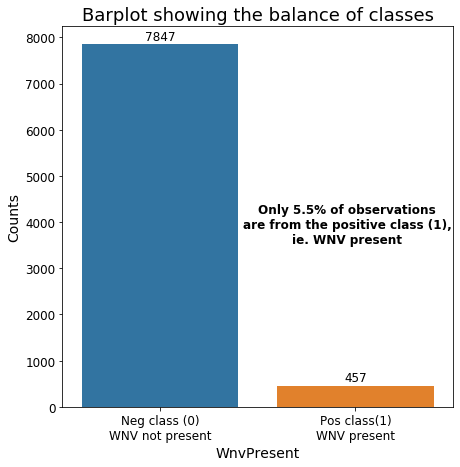

In [15]:
# Plotting the balance of classes on a countplot.

neg_class_count = train['WnvPresent'].value_counts()[0]
pos_class_count = train['WnvPresent'].value_counts()[1]
pos_class_pct = train['WnvPresent'].value_counts(normalize=True)[1] * 100

plt.figure(figsize=(7,7))

ax = sns.countplot(x='WnvPresent', data=train)

ax.set_xticklabels(['Neg class (0)\nWNV not present', 'Pos class(1)\nWNV present'])
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("WnvPresent", fontsize=14)
plt.ylabel("Counts", fontsize=14)

plt.title("Barplot showing the balance of classes", fontsize=18)

plt.text(x=0, y=neg_class_count+100, s=str(neg_class_count), fontsize=12, ha='center')
plt.text(x=1, y=pos_class_count+100, s=str(pos_class_count), fontsize=12, ha='center')

plt.figtext(x=0.69, 
            y=0.45, 
            s=f"Only {round(pos_class_pct, 2)}% of observations\nare from the positive class (1),\nie. WNV present", 
            fontsize=12, 
            fontweight='semibold',
            ha='center'
           )

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplot_wnvpresent.png', bbox_inches='tight');

As seen above, the **classes are very unbalanced**. Of the 8304 observations, only 457 (5.5%) are from the positive class, ie. the West Nile Virus is present *(WnvPresent = 1)*. 7847 (94.5%) observations are from the negative class, ie. West Nile Virus is not present *(WnvPresent = 0)*.

Setting a baseline accuracy of 94.5% using the current balance of classes would not serve our purpose in this case. If a baseline accuracy of 94.5% is set, it would imply that we can predict all observations to be West Nile Virus not present, and we would be correct 94.5% of the time. However, this would not help us in predicting the cases when the virus is actually present.

**So, in order to model the data in this case, we will have to explore potential ways to balance the two classes before modelling.**

In [16]:
# Creating a copy of train for plotting on an interactive map.
train_copy = train.copy()

# Setting the date column as index.
train_copy.set_index('Date', inplace=True)

In [17]:
train_copy['Latitude'].min(), train_copy['Latitude'].max()

(41.644612, 42.01743)

In [18]:
train_copy['Longitude'].min(), train_copy['Longitude'].max()

(-87.930995, -87.531635)

In [19]:
# Setting the coordinates of lower left corner and upper right corner of the map image for plotting.

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# Importing the mapdata file.
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

In [20]:
# Creating a list of unique years found in the train data.

train_years = list(train_copy.index.year.unique())
train_years

[2007, 2009, 2011, 2013]

In [21]:
# Creating a list of unique months found in the train data.

train_months = list(train_copy.index.month.unique())
train_months

[5, 6, 7, 8, 9, 10]

In [22]:
# Defining a function to polt an interactive scatter plot with the mapdata as background.
# The function accepts the year and month values as input from the user interaction
# and plots the Latitude and Longitude coordinates, using WnvPresent column for colour.

def train_lat_long_plotter(Year=train_years[0], Month=train_months[0]):
    
    plt.figure(figsize=(9,9))
    
    # Setting the mapdata image as the background of the map.
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
    
    # Converting the user input Year and Month values to type string for easier filtering of dataframe later.
    year = str(Year)
    month = 0
    if Month<10:
        month = "0"+str(Month)
    else:
        month = str(Month)
        
    date_str = year+"-"+month
    
    # Creating empty dataframes for WnvPresent=0 and WnvPresent=1 with only Latitude and Longitude columns.
    temp_df_0 = pd.DataFrame(columns=['Latitude', 'Longitude'])
    temp_df_1 = pd.DataFrame(columns=['Latitude', 'Longitude'])
    
    # Filtering the train_copy dataframe by WnvPresent==0 & 1 and by the date string defined above.
    # Taking only Latitude and Longitude columns and assigning them to empty dataframes created above.
    # We use try-except loops so as to suppress KeyErrors in case the filtered dataframes happen to be empty for the given date string.
    try:
        mask_0 = train_copy['WnvPresent']==0
        temp_df_0 = train_copy[mask_0][date_str].loc[:, ['Latitude', 'Longitude']]
    except:
        pass
    
    try:
        mask_1 = train_copy['WnvPresent']==1
        temp_df_1 = train_copy[mask_1][date_str].loc[:, ['Latitude', 'Longitude']]
    except:
        pass
    
    plt.scatter(x=temp_df_0['Longitude'], y=temp_df_0['Latitude'], c='blue', marker='o', s=20)
    plt.scatter(x=temp_df_1['Longitude'], y=temp_df_1['Latitude'], c='red', marker='o', s=60)
    
    plt.title("Map showing presence of WNV across Chicago", fontsize=18)
    
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    
    plt.legend(fontsize=12, labels=['WNV not present (0)', 'WNV present (1)'])

In [23]:
interact(train_lat_long_plotter, Year=train_years, Month=train_months);

interactive(children=(Dropdown(description='Year', options=(2007, 2009, 2011, 2013), value=2007), Dropdown(des…

In [24]:
# Calculating proportions of WNV present with the sprayed status of traps (Sprayed column) to be used in the barplots below.

wnv_spray = len(train[(train['WnvPresent']==1) & (train['Sprayed']==1)])
NOTwnv_spray = len(train[(train['WnvPresent']==0) & (train['Sprayed']==1)])
wnv_NOTspray = len(train[(train['WnvPresent']==1) & (train['Sprayed']==0)])
NOTwnv_NOTspray = len(train[(train['WnvPresent']==0) & (train['Sprayed']==0)])

pct_wnv_not_sprayed = wnv_NOTspray / (wnv_NOTspray + NOTwnv_NOTspray) * 100
pct_wnv_sprayed = wnv_spray / (wnv_spray + NOTwnv_spray) * 100

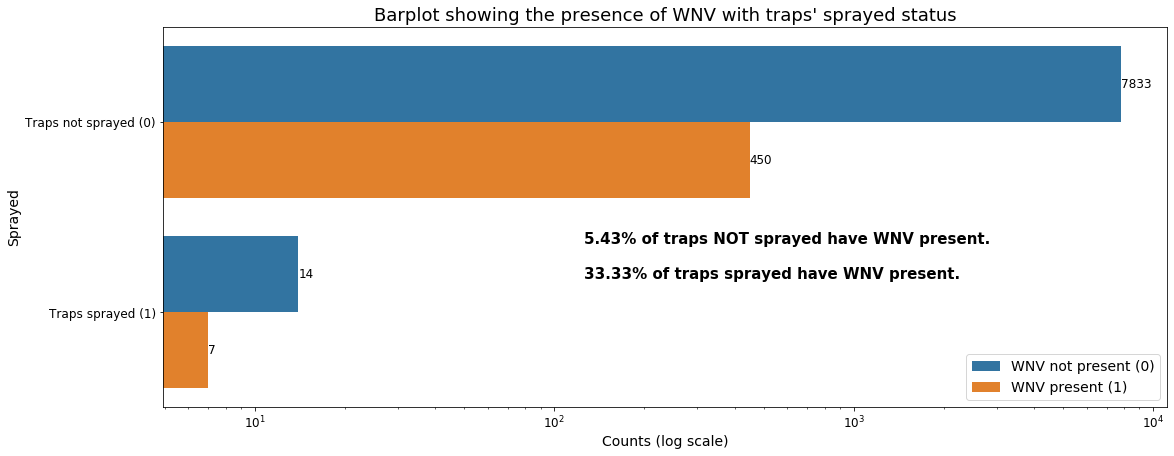

In [25]:
# Plotting barplot showing the presence of WNV with traps' sprayed status.

plt.figure(figsize=(18,7))

ax = sns.countplot(y='Sprayed', hue='WnvPresent', data=train)

# Setting the X-axis (counts) to be on a log scale so that the WNV present bars can be more prominently seen.
ax.set_xscale("log")


ax.set_yticklabels(['Traps not sprayed (0)', 'Traps sprayed (1)'])
ax.tick_params(axis='both', labelsize=12)

plt.legend(fontsize=14, labels=['WNV not present (0)', 'WNV present (1)'])

plt.xlabel("Counts (log scale)", fontsize=14)
plt.ylabel("Sprayed", fontsize=14)

plt.title("Barplot showing the presence of WNV with traps' sprayed status", fontsize=18)

plt.text(x=NOTwnv_NOTspray, y=-0.18, s=str(NOTwnv_NOTspray), fontsize=12)
plt.text(x=wnv_NOTspray, y=0.22, s=str(wnv_NOTspray), fontsize=12)
plt.text(x=NOTwnv_spray, y=0.82, s=str(NOTwnv_spray), fontsize=12)
plt.text(x=wnv_spray, y=1.22, s=str(wnv_spray), fontsize=12)

plt.figtext(x=0.45, y=0.45, s=f"{round(pct_wnv_not_sprayed, 2)}% of traps NOT sprayed have WNV present.", fontsize=15, fontweight='semibold')
plt.figtext(x=0.45, y=0.38, s=f"{round(pct_wnv_sprayed, 2)}% of traps sprayed have WNV present.", fontsize=15, fontweight='semibold')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplot_sprayed_wnvpresent.png', bbox_inches='tight');

The above plot appears to show that **a higher proportion of mosquito traps which have been sprayed have WNV present in them, as compared to traps which have not been sprayed**. This may indicate that spraying may not be a very effective method of controlling the presence of WNV in mosquitoes.

In [26]:
# Calculating proportions of WNV present with the species of mozzies (Species_... columns) to be used in the barplot below.

wnv_pip = len(train[(train['WnvPresent']==1) & (train['Species_CULEX PIPIENS']==1)])
NOTwnv_pip = len(train[(train['WnvPresent']==0) & (train['Species_CULEX PIPIENS']==1)])
wnv_res = len(train[(train['WnvPresent']==1) & (train['Species_CULEX RESTUANS']==1)])
NOTwnv_res = len(train[(train['WnvPresent']==0) & (train['Species_CULEX RESTUANS']==1)])
wnv_pipres = len(train[(train['WnvPresent']==1) & (train['Species_CULEX PIPIENS/RESTUANS']==1)])
NOTwnv_pipres = len(train[(train['WnvPresent']==0) & (train['Species_CULEX PIPIENS/RESTUANS']==1)])

pct_wnv_pip = wnv_pip / (wnv_pip + NOTwnv_pip) * 100
pct_wnv_res = wnv_res / (wnv_res + NOTwnv_res) * 100
pct_wnv_pipres = wnv_pipres / (wnv_pipres + NOTwnv_pipres) * 100

In [27]:
# Creating a list of species from the 3 one-hot encoded columns of mozzie species to be used in the barplot below.

species = []

for i in train.index:
    cur_species = ''
    
    if train.loc[i, 'Species_CULEX PIPIENS']==1:
        cur_species = 'CULEX PIPIENS'
    elif train.loc[i, 'Species_CULEX RESTUANS']==1:
        cur_species = 'CULEX RESTUANS'
    elif train.loc[i, 'Species_CULEX PIPIENS/RESTUANS']==1:
        cur_species = 'CULEX PIPIENS/RESTUANS'
    
    species.append(cur_species)

len(species)

8304

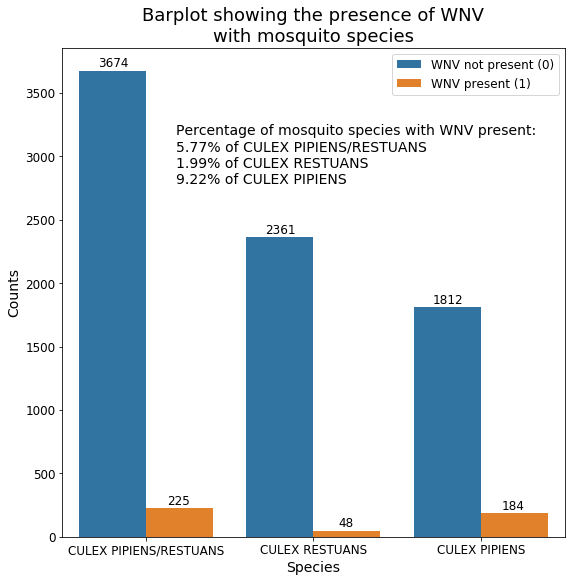

In [28]:
# Plotting barplot showing the presence of WNV with species of mozzies.

plt.figure(figsize=(9,9))

ax = sns.countplot(x=species, hue='WnvPresent', data=train)

ax.tick_params(axis='both', labelsize=12)

plt.legend(fontsize=12, labels=['WNV not present (0)', 'WNV present (1)'])

plt.xlabel("Species", fontsize=14)
plt.ylabel("Counts", fontsize=14)

plt.title("Barplot showing the presence of WNV\nwith mosquito species", fontsize=18)

plt.text(x=-0.195, y=NOTwnv_pipres+30, s=str(NOTwnv_pipres), fontsize=12, ha='center')
plt.text(x=0.195, y=wnv_pipres+30, s=str(wnv_pipres), fontsize=12, ha='center')
plt.text(x=0.805, y=NOTwnv_res+30, s=str(NOTwnv_res), fontsize=12, ha='center')
plt.text(x=1.195, y=wnv_res+30, s=str(wnv_res), fontsize=12, ha='center')
plt.text(x=1.805, y=NOTwnv_pip+30, s=str(NOTwnv_pip), fontsize=12, ha='center')
plt.text(x=2.195, y=wnv_pip+30, s=str(wnv_pip), fontsize=12, ha='center')

text_str = f"Percentage of mosquito species with WNV present:\n{round(pct_wnv_pipres, 2)}% of CULEX PIPIENS/RESTUANS\n{round(pct_wnv_res, 2)}% of CULEX RESTUANS\n{round(pct_wnv_pip, 2)}% of CULEX PIPIENS"
plt.figtext(x=0.3, y=0.67, s=text_str, fontsize=14)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplot_species_wnvpresent.png', bbox_inches='tight');

The above plot shows that **CULEX PIPIENS species of mosquitoes have the highest proportion of WNV present in them (9.22%)**. On the other hand, **CULEX RESTUANS have the lowest proportion of presence of WNV in them (1.99%)**.

In [29]:
train.columns

Index(['Date', 'Latitude', 'Longitude', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'WnvPresent', 'Sprayed', 'Avg Pos Dist', 'Tmax', 'Tmin', 'Tavg',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunrise', 'Sunset',
       'bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'gr', 'hz', 'mi', 'ra', 'sn', 'sq',
       'ts', 'vc'],
      dtype='object')

In [30]:
# Filtering out columns of continuous variables.

continuous_vars = train.columns[8:24]
continuous_vars

Index(['Avg Pos Dist', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Sunrise', 'Sunset'],
      dtype='object')

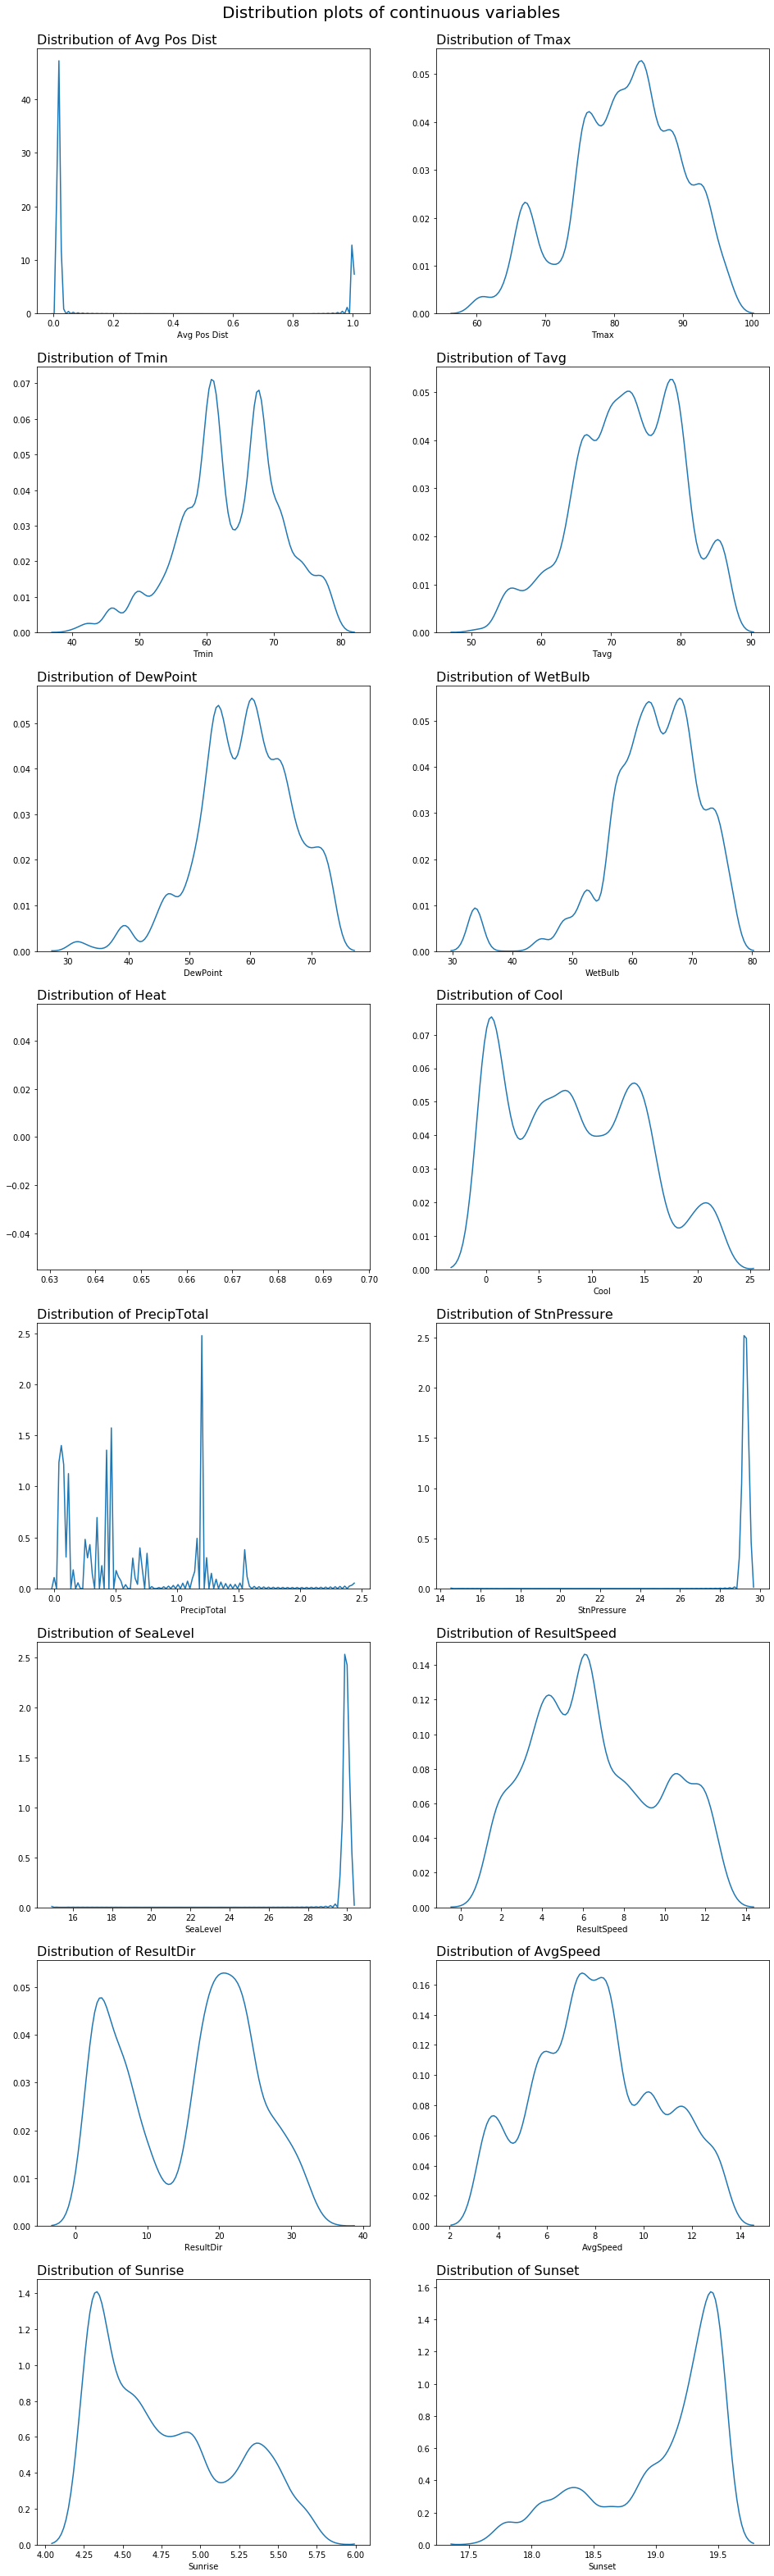

In [31]:
# Plotting distribution plots of all continuous variables.

fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(16,56))

ax = ax.ravel()

for i, col in enumerate(continuous_vars):
    
    ax[i].set_title(f"Distribution of {col}", fontsize=16, loc='left')
    
    # We use try & except because some variables are not normally distributed and throw this error during kde calculation:
    # "RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density." 
    try:
        sns.distplot(train[col], ax=ax[i], hist=False, kde=True)
    except:
        pass

fig.suptitle(x=0.5, y=0.893, t="Distribution plots of continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/distplots_weather_continuous_vars.png', bbox_inches='tight')

From the above distribution plots, we see that **none of the continuous variables are normally distributed**. Hence, we will **use the Kendall correlation method** to determine the correlation between *WnvPresent* and continuous variables (instead of the Pearson correlation method).

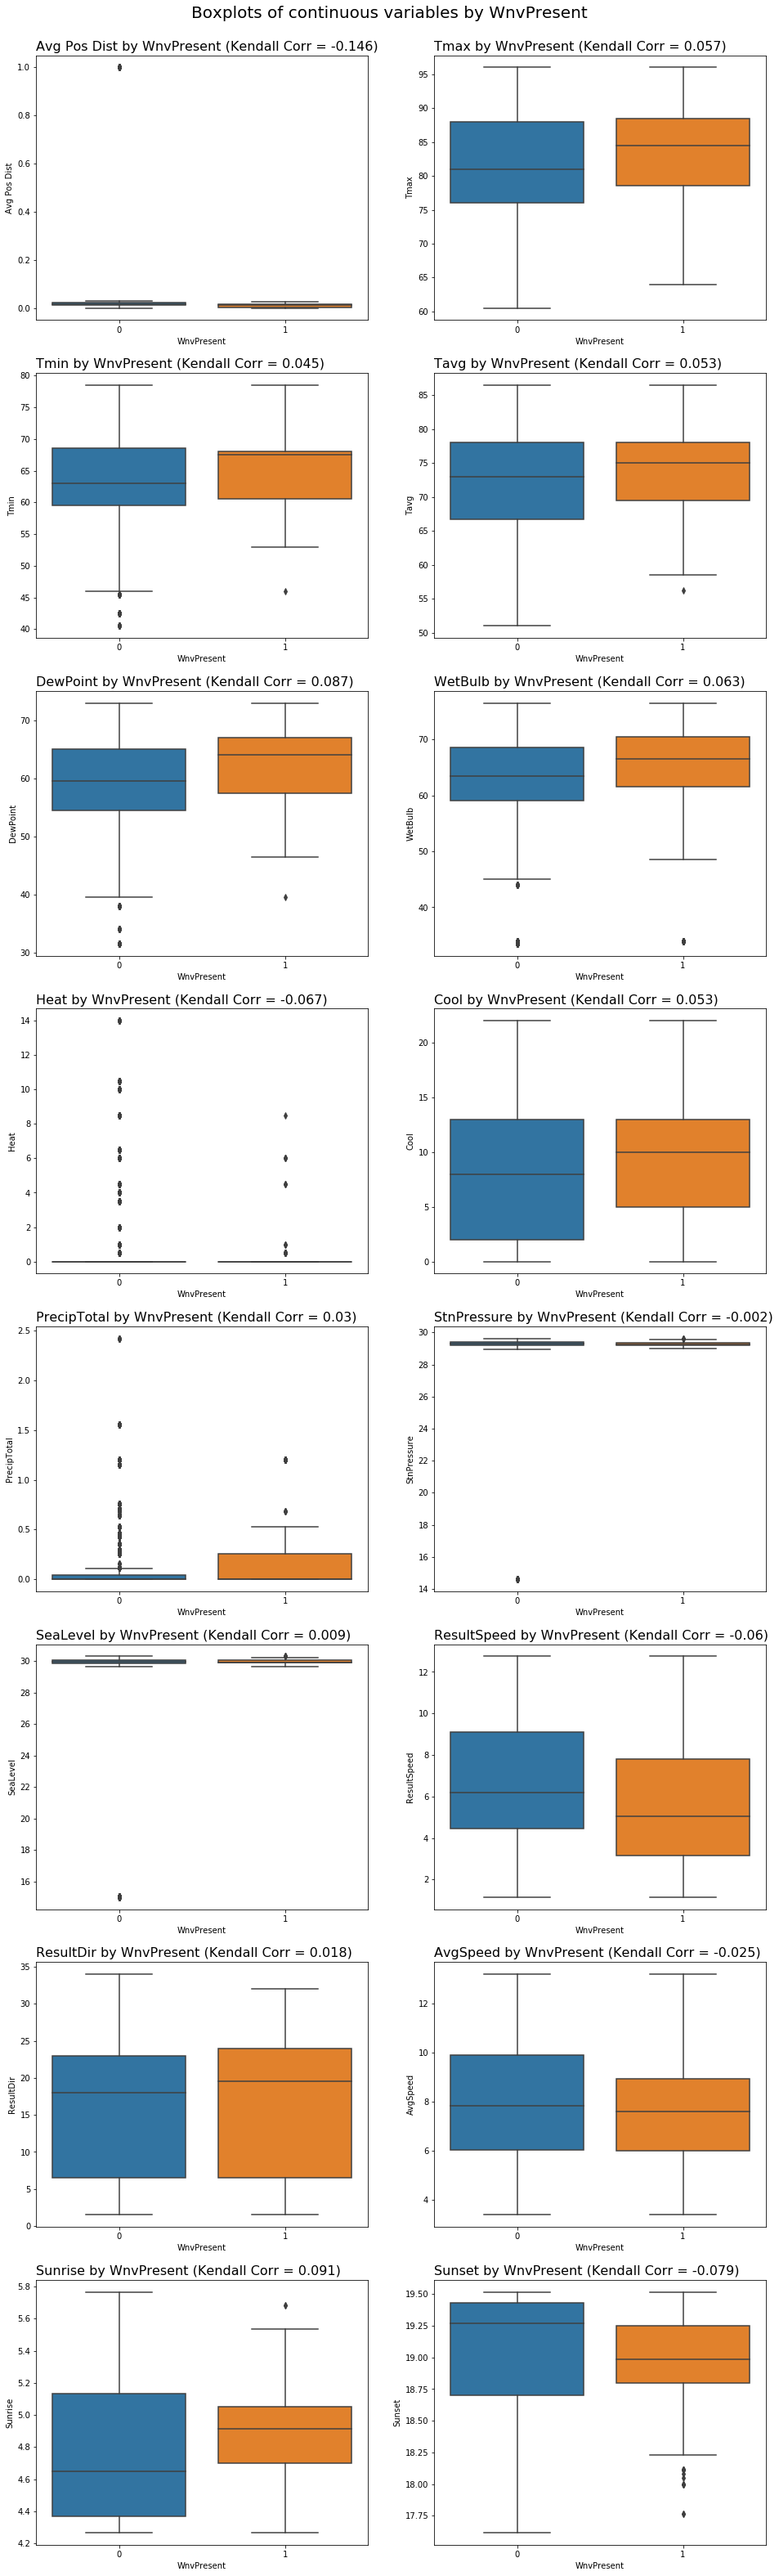

In [32]:
# Plotting boxplots of all continuous variables by WnvPresent.

fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(16,56))

ax = ax.ravel()

for i, col in enumerate(continuous_vars):
    
    sns.boxplot(data=train, x='WnvPresent', y=col, ax=ax[i])
    # sns.stripplot(data=train, x='WnvPresent', y=col, ax=ax[i])
    
    kendall_coef = str(round(train[['WnvPresent', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"{col} by WnvPresent (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.895, t="Boxplots of continuous variables by WnvPresent", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/boxplots_continuous_vars_wnvpresent.png', bbox_inches='tight')

The above boxplots show the distribution of the continuous variables by *WnvPresent* column. It is noted that columns such as *Heat* and *StnPressure* have outliers among the data. However, upon further investigation, it is noted that these outlier observations form a significant proportion of the data itself, and thus, cannot just be dropped.

It is also noted that **columns such as *Avg Pos Dist* (newly engineered feature), *DewPoint*, *Sunrise* and *Sunset* are some of the most strongly correlated features to our target variable *WnvPresent***, as seen from their Kendall correlation coefficient values. We expect these columns to be the most important features in our classification models below.

In [33]:
# Filtering out columns of weather conditions.

weather_conditions = train.columns[24:]
weather_conditions

Index(['bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'gr', 'hz', 'mi', 'ra', 'sn', 'sq',
       'ts', 'vc'],
      dtype='object')

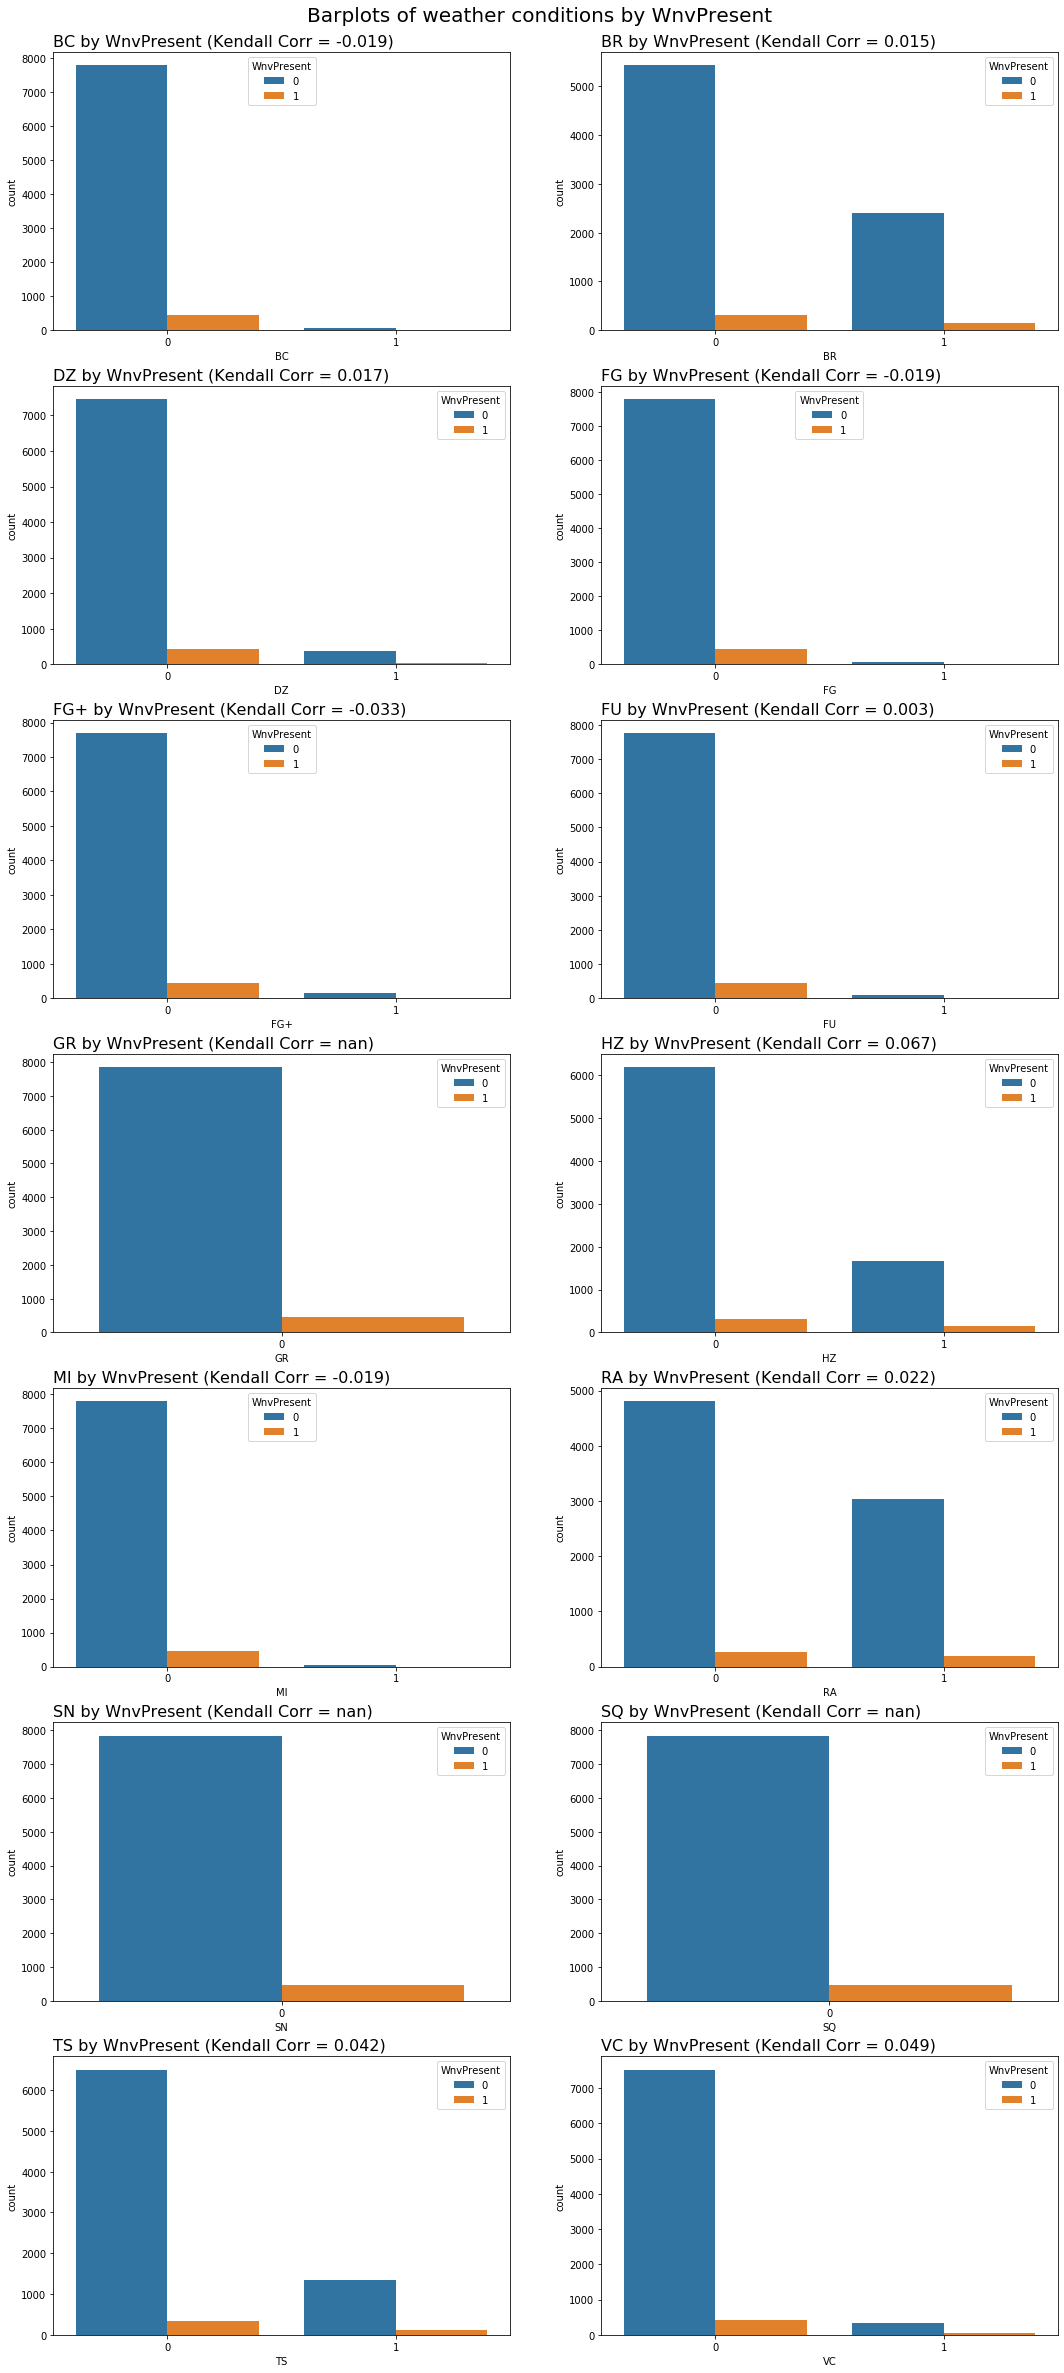

In [34]:
# Plotting barplots showing the presence of WNV with weather conditions.

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(18,42))

ax = ax.ravel()

for i, col in enumerate(weather_conditions):
    
    sns.countplot(x=col, hue='WnvPresent', data=train, ax=ax[i])
    
    kendall_coef = str(round(train[['WnvPresent', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_xlabel(col.upper())
    ax[i].set_title(f"{col.upper()} by WnvPresent (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.895, t="Barplots of weather conditions by WnvPresent", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplots_weather_conditions_wnvpresent.png', bbox_inches='tight')

In [35]:
# Creating a new dataframe to group all observations by unique dates.

wnv_by_dates = pd.DataFrame(columns=['unique_dates', 'months', 'years', 'wnv_present_num', 'wnv_total', 't_max', 't_min'])

# Creating a column of all unique dates of observations found in train dataframe.
wnv_by_dates['unique_dates'] = np.sort(train['Date'].unique())

# Creating columns of months and years of the unique dates from above.
wnv_by_dates['months'] = wnv_by_dates['unique_dates'].map(lambda date : date.month)
wnv_by_dates['years'] = wnv_by_dates['unique_dates'].map(lambda date : date.year)


wnv_present_num = []
wnv_total = []
t_max = []
t_min = []

for date in wnv_by_dates['unique_dates']:
    
    # Creating columns indicating no. of observations with WnvPresent = 1 and total no. of observations for each unique date.
    wnv_present_num.append(len(train[(train['Date']==date) & (train['WnvPresent']==1)]))
    wnv_total.append(len(train[train['Date']==date]))
    
    # Creating columns of Tmax and Tmin for each unique date
    t_max.append(train[train['Date']==date]['Tmax'].iloc[0])
    t_min.append(train[train['Date']==date]['Tmin'].iloc[0])
    
wnv_by_dates['wnv_present_num'] = wnv_present_num
wnv_by_dates['wnv_total'] = wnv_total
wnv_by_dates['t_max'] = t_max
wnv_by_dates['t_min'] = t_min

In [36]:
wnv_by_dates.head()

,unique_dates,months,years,wnv_present_num,wnv_total,t_max,t_min
0,2007-05-29,5,2007,0,25,80.0,56.0
1,2007-06-05,6,2007,0,60,67.5,49.5
2,2007-06-26,6,2007,0,68,92.5,67.0
3,2007-06-29,6,2007,0,46,80.5,65.0
4,2007-07-02,7,2007,0,71,75.5,61.5


In [37]:
wnv_by_dates.shape

(95, 7)

In [38]:
# Checking the unique values of months in the new dataframe wnv_by_dates.

wnv_by_dates['months'].unique()

array([ 5,  6,  7,  8,  9, 10], dtype=int64)

In [39]:
# Checking the unique values of years in the new dataframe wnv_by_dates.

wnv_by_dates['years'].unique()

array([2007, 2009, 2011, 2013], dtype=int64)

In [40]:
# Grouping all observations by years and months and taking sum of observations with WnvPresent = 1 and total no. of observations for each month.

wnv_num_total_grouped = wnv_by_dates.groupby(['years', 'months'])['wnv_present_num', 'wnv_total'].sum()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Grouping all observations by years and months and taking mean of Tmax and Tmin for each month.

tmax_tmin_grouped = wnv_by_dates.groupby(['years', 'months'])['t_max', 't_min'].mean()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# Merging all of the above into one dataframe for easier plotting of lineplots below.

grouped_wnv_by_dates = pd.merge(wnv_num_total_grouped, tmax_tmin_grouped, on=['years', 'months'])
grouped_wnv_by_dates.reset_index(inplace=True)
grouped_wnv_by_dates

,years,months,wnv_present_num,wnv_total,t_max,t_min
0,2007,5,0,25,80.000000,56.000000
1,2007,6,0,174,80.166667,60.500000
2,2007,7,3,441,83.666667,65.916667
3,2007,8,159,1256,84.038462,65.884615
4,2007,9,25,607,75.625000,57.937500
5,2007,10,2,190,85.750000,60.250000
6,2009,5,0,56,66.500000,42.500000
7,2009,6,0,461,73.666667,54.333333
8,2009,7,5,606,77.142857,61.571429
9,2009,8,9,322,85.500000,68.375000


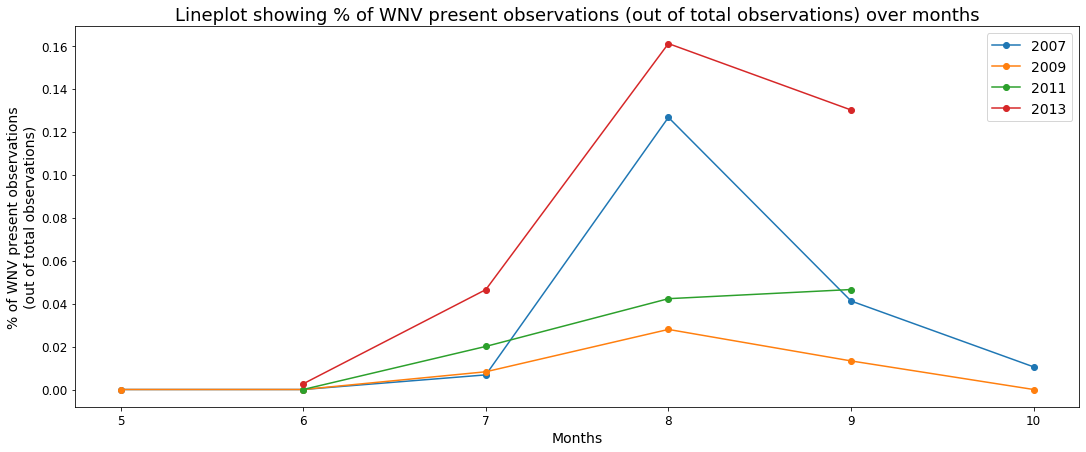

In [43]:
# Plotting lineplot to show presence of WNV over months of different years.

plt.figure(figsize=(18, 7))

for year in grouped_wnv_by_dates['years'].unique():
    
    temp_df = grouped_wnv_by_dates[grouped_wnv_by_dates['years']==year]
    
    plt.plot(temp_df['months'], temp_df['wnv_present_num']/temp_df['wnv_total'], marker='o', label=str(year))

plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=12)

plt.xlabel("Months", fontsize=14)
plt.ylabel("% of WNV present observations\n(out of total observations)", fontsize=14)

plt.title("Lineplot showing % of WNV present observations (out of total observations) over months", loc='center', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/lineplot_wnvpresent_over_months.png', bbox_inches='tight');

The above plot shows the percentage of WNV present observations by months for the four years of data given. It is seen that **the month of August sees the highest proportion of WNV present observations from all the tests of mosquito traps that are conducted**. Correlating this to the [weather conditions in Chicago](https://weatherspark.com/y/14091/Average-Weather-in-Chicago-Illinois-United-States-Year-Round), this implies that WNV is most prevalent in the summer season when the temperatues are at their highest. Coincidentally, it is also the time of the year when the rainfall and precipitation is at it's peak, with highest levels of humidity throughout the year. Furthermore, wind speed during this time of the year is at it's lowest and the average water temperature in the water bodies is 20-25 deg C, which may be ideal conditions for the mosquitoes to fly around and lay eggs.

## Model Preparation

### Modelling Approach

As seen above in the EDA section, the classes in this case are very unbalanced. So, before we start any classification modelling, we will have to balance the two classes using any one of the various class balancing techniques available. **Some of the techniques that will be used in this project are over-sampling using *imblearn SMOTE* or *ADASYN*, under-sampling using *imblearn ClusterCentroids* and weighing of classes according to their proportions using the hyperparameter *class_weight='balanced'* (only available in certain classifiers).**

We will begin the classification modelling by using the ***SMOTE* balancing technique with **four different classifiers - *LogisticRegression, RandomForestClassifier, SVC and GradientBoosting*** - and then compare their performaces using the evaluation metrics explained in the next section. Based on the metrics scores, the **best performing classifier will then be paired with three other balancing techniques - *ADASYN, ClusterCentroids* and using hyperparameter *class_weight='balanced'*** - to select the best performing combination of class balancing technique and classifier for this project.

Among the four different balancing techniques mentioned above, we decided to choose *SMOTE* as our first technique to be paired with different classifiers because of the following reasons:
- ***SMOTE***
    - *Synthetic Minority Oversampling Technique (SMOTE)* is a very commonly used class balancing technique.
    - It is an over-sampling technique, which means it manufactures synthetic data from the minority class instead of getting rid of data from the majority class (which may result in significant loss of information in our case, given the imbalance in the two classes).
- ***ADASYN***
    - *Adaptive Synthetic (ADASYN)*, like *SMOTE*, is an over-sampling technique, but not as commonly used.
- ***ClusterCentroids***
    - *ClusterCentroids* is an under-sampling technique, which means it gets rid of data from the majority class in order to balance the two classes.
    - Given the imbalance between the two classes in this case, this would result in a significant loss of information from the majority class which may affect the performance of the model.
- **Hyperparameter *class_weight='balanced'***
    - This technique weighs the data points from each class according to their proportions in the sample population, so as to balance their overall "effect" in the classification model.
    - This hyperparameter is not available in all classifiers that we intend to use, such as *GradientBoostingClassifier*.

### Classification Metrics

In the context of this project, we define our **positive class as the presence of WNV *(WnvPresent = 1)*, and the negative class as the absence of WNV *(WnvPresent = 0)***.

*Accuracy* is defined as the total number of correct predictions over the total number of predictions made. In this context, this refers to the total number of correctly predicted mosquito traps which contain / do not contain WNV over the total number of predictions that we make.

While *accuracy* is a good overall measure of the model's performance, a high score value does not necessarily mean the model is predicting each class with the same performance. For example, the model could correctly predict all traps with no WNV and only a few traps with WNV, and the *accuracy* score could still be a high value (given the imbalance in the classes). So, in addition to *accuracy*, it would be good to also look at the *sensitivity* and *specificity*, to see how well the model is predicting traps with / without WNV.

*Sensitivity (True Positive Rate)* is the amount of true positives over the number of true positives and false negatives. *Specificity (True Negative Rate)*, on the other hand, is the amount of true negatives over the number of true negatives and false positives. In this context, **false negative *(type II error)* refers to mosquito traps that contain WNV but are predicted falsely to not contain WNV, whereas false positive *(type I error)* refers to mosquito traps that do not contain WNV but are predicted falsely to contain WNV**. Given that we are dealing with a virus that has the potential to seriously affect community health if not contained properly, it is more important to reduce the number of false negatives than false positives. Hence, **in addition to optimizing for *accuracy*, it is more important to optimize our classification model for *sensitivity* than for *specificity***.

**Speaking in terms of costs involved for the City of Chicago and the Chicago Department of Public Health (CDPH), a large number of false positives would result in increased costs for spraying airborne pesticides to control adult mosquito populations. On the other hand, a large number of false negatives could potentially lead to an outbreak of WNV in the city which would result in increased healthcare costs, economic losses to victims, employers and businesses, and an overall negative impact on the economy (as is evident from the current COVID-19 pandemic).** So, as explained above, it is more important to reduce the number of false negatives than false positives. Hence, in addition to optimizing for *accuracy*, it is more important to optimize our classification model for *sensitivity* than for *specificity*.

In [44]:
# Defining features dataframe X and target variable y from train dataframe.

X = train[[col for col in train.columns if col not in ['Date', 'WnvPresent']]]
y = train['WnvPresent']

In [45]:
# Preparing test dataframe for predictions and submissions to kaggle later.

act_test_X = test[[col for col in test.columns if col not in ['Date', 'Id']]]

In [46]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [47]:
X_train.head()

,Latitude,Longitude,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Sprayed,Avg Pos Dist,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
942,41.822536,-87.666343,0,1,0,0,1.000000,82.5,61.5,72.00,55.0,63.0,0.0,7.5,0.000,29.395,30.095,3.05,10.5,3.95,4.600000,19.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4069,41.992478,-87.862995,1,0,0,0,0.000000,89.0,68.5,78.75,61.0,67.5,0.0,14.0,0.000,29.350,30.030,8.50,19.0,8.80,4.983333,18.900000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5362,41.867108,-87.654224,0,1,0,0,0.012672,84.0,71.5,77.75,62.5,68.0,0.0,13.0,0.005,29.205,29.870,6.10,5.5,8.25,4.650000,19.300000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2001,41.781416,-87.776532,0,1,0,0,0.017086,78.5,60.5,69.50,55.0,61.5,0.0,5.0,0.000,29.410,30.075,3.65,11.0,5.00,5.183333,18.616667,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3466,41.801498,-87.763416,0,0,1,0,0.027500,76.5,62.0,69.25,54.5,60.5,0.0,4.5,0.000,29.210,29.885,5.90,7.0,7.25,4.383333,19.500000,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [48]:
X_train.shape

(6228, 36)

In [49]:
X_test.head()

,Latitude,Longitude,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Sprayed,Avg Pos Dist,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
3391,41.825610,-87.726549,0,0,1,0,0.022351,67.0,60.0,63.50,53.0,57.5,1.0,0.0,0.000,28.975,29.645,8.50,30.0,8.70,4.316667,19.516667,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6660,41.682587,-87.707973,0,1,0,0,0.019559,83.0,67.5,75.25,60.5,65.5,0.0,10.5,0.080,28.940,29.625,9.75,30.0,10.35,4.316667,19.516667,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4820,41.778297,-87.752411,0,1,0,0,0.020156,79.5,67.0,73.25,67.0,69.0,0.0,8.5,0.705,29.040,29.710,7.10,16.0,8.80,4.266667,19.500000,0,1,0,0,0,0,0,0,0,1,0,0,1,0
8132,41.662014,-87.724608,1,0,0,0,0.010176,94.0,68.5,81.25,69.0,73.5,0.0,16.5,0.000,29.185,29.860,8.75,20.0,9.65,5.416667,18.233333,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2155,41.726465,-87.585413,0,1,0,0,0.011834,84.5,61.5,73.00,56.5,63.0,0.0,8.0,0.000,29.440,30.140,4.50,21.0,5.50,5.300000,18.433333,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
X_test.shape

(2076, 36)

In [51]:
# Checking the distribution of classes in y_train.

y_train.value_counts()

0    5885
1     343
Name: WnvPresent, dtype: int64

In [52]:
# Checking the distribution of classes to ensure it is same as y_test.

y_train.value_counts(normalize=True)

0    0.944926
1    0.055074
Name: WnvPresent, dtype: float64

In [53]:
# Checking the distribution of classes to ensure it is same as y_train.

y_test.value_counts(normalize=True)

0    0.945087
1    0.054913
Name: WnvPresent, dtype: float64

In [54]:
# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

In [55]:
# Transforming X_test to the same scale.

X_test_sc = ss.transform(X_test)

In [56]:
# Transforming actual test dataframe to the same scale (to generate predictions for kaggle submission later).

act_test_X_sc = ss.transform(act_test_X)

### Class Balancing Techniques

In [57]:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
clustercentroids = ClusterCentroids(random_state=42)

In [58]:
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)
X_train_sc_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_sc, y_train)
X_train_sc_clustercentroids, y_train_clustercentroids = clustercentroids.fit_resample(X_train_sc, y_train)

In [59]:
# Checking the distribution of classes with SMOTE balancing technique.

y_train_smote.value_counts()

1    5885
0    5885
Name: WnvPresent, dtype: int64

In [60]:
# Checking the distribution of classes with SMOTE balancing technique.

y_train_smote.value_counts(normalize=True)

1    0.5
0    0.5
Name: WnvPresent, dtype: float64

In [61]:
# Checking the distribution of classes with ADASYN balancing technique.

y_train_adasyn.value_counts()

1    5888
0    5885
Name: WnvPresent, dtype: int64

In [62]:
# Checking the distribution of classes with ADASYN balancing technique.

y_train_adasyn.value_counts(normalize=True)

1    0.500127
0    0.499873
Name: WnvPresent, dtype: float64

In [63]:
# Checking the distribution of classes with ClusterCentroids balancing technique.

y_train_clustercentroids.value_counts()

1    343
0    343
Name: WnvPresent, dtype: int64

In [64]:
# Checking the distribution of classes with ClusterCentroids balancing technique.

y_train_clustercentroids.value_counts(normalize=True)

1    0.5
0    0.5
Name: WnvPresent, dtype: float64

As explained above, all three balancing techniques from the *imblearn* library help to balance the proportions of the classes in our sample population.

***SMOTE* and *ADASYN* are over-sampling techniques**, which means they create copies of the minority class data points with small variations, making the synthetic samples more diverse (as explained [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)). So, as shown above, **the number of data points in the minority class increases to match the number of data points in the majority class (5885)**.

***ClusterCentroids* is an under-sampling technique**, which means it gets rid of data from the majority class in order to balance the two classes. It does so by finding clusters of data points in the majority class, and then inferring which data points in the majority class are 'central' in that cluster. The model then uses those centroids (central points) for the majority class instead of all the actual data points (as explained [here](https://dev.to/lberlin/balancing-the-imbalanced-2bgo)). So, as shown above, **the number of data points in the majority class decreases significantly to match the number of data points in the minority class (343)**.

## Classification Modelling

### *GridSearchCV* for *LogisticRegression* with *SMOTE* balancing technique

In [65]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and LogisticRegression.

pipe1 = make_pipeline(SMOTE(random_state=42),
                      LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=500, tol=0.005)
                     )

In [66]:
pipe1.get_params()

{'memory': None,
 'steps': [('smote',
   SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto')),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=500,
                      multi_class='auto', n_jobs=None, penalty='elasticnet',
                      random_state=42, solver='saga', tol=0.005, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'smote': SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto'),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=500,
                    multi_class='auto', n_jobs=None, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.005, verbose=0,
                    warm_start=False),
 'smote__k_neighbors': 5,
 'smote__n_jobs'

In [67]:
# Establishing ranges of hyperparameters C and l1_ratio for GridSearchCV.

pipe1_params = {'logisticregression__C': np.logspace(-2, 2, 5),
                'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
               }

In [68]:
# Creating a GridSearchCV object for the pipeline object defined above.

gs_pipe1 = GridSearchCV(pipe1, 
                        param_grid=pipe1_params, 
                        cv=5, 
                        scoring='roc_auc'
                       )

In [69]:
# Fitting GridSearchCV with SMOTE and LogisticRegression on X_train_sc and y_train.

gs_pipe1.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=42,
                                              sampling_strategy='auto')),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=500,
                                                           multi_class='auto

In [70]:
# Best combination of hyperparameters suggested by GridSearchCV.

gs_pipe1.best_params_

{'logisticregression__C': 100.0, 'logisticregression__l1_ratio': 0.75}

In [71]:
# Best roc_auc score obtained by above combination of hyperparameters.

gs_pipe1.best_score_

0.8308626878774117

In [72]:
# Scoring the model on training dataset (roc_auc score).

gs_pipe1.score(X_train_sc, y_train)

0.8477267153978961

In [73]:
# Scoring the model on testing dataset (roc_auc score).

gs_pipe1.score(X_test_sc, y_test)

0.8584129155712931

Even though the best parameters were suggested above by *GridSearchCV*, the model was further tuned manually using different combinations of hyperparameters. ***GridSearchCV* only optimizes the model using a single scoring parameter (set as *'roc_auc'* above). However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required.**

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [74]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and LogisticRegression using best params suggested by GridSearchCV above.

lr_smote_pipe1 = make_pipeline(SMOTE(random_state=42),
                               LogisticRegression(penalty='elasticnet',
                                                  solver='saga',
                                                  C=100,
                                                  l1_ratio=0.75,
                                                  random_state=42,
                                                  max_iter=500,
                                                  tol=0.005
                                                 )
                              )

In [75]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

lr_smote_pipe1.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.75, max_iter=500,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=0.005, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [76]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc1 = lr_smote_pipe1.score(X_train_sc, y_train)
train_acc1

0.7074502247912653

In [77]:
# Estimated Testing Accuracy

est_test_acc1 = cross_val_score(lr_smote_pipe1, X_train_sc, y_train, cv=5).mean()
est_test_acc1

0.6976570165090539

In [78]:
# Actual Testing Accuracy

test_acc1 = lr_smote_pipe1.score(X_test_sc, y_test)
test_acc1

0.7119460500963392

In [79]:
# Generating predictions on testing dataset using the model above.

y_pred1 = lr_smote_pipe1.predict(X_test_sc)

In [80]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba1 = lr_smote_pipe1.predict_proba(X_test_sc)

In [81]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()

In [82]:
conf_mat1 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat1

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,97 (True Pos),581 (False Pos)
Predicted WnvPresent=0,17 (False Neg),1381 (True Neg)


In [83]:
sensitivity1 = tp/(tp+fn)
sensitivity1

0.8508771929824561

In [84]:
specificity1 = tn/(tn+fp)
specificity1

0.7038735983690112

In [85]:
precision1 = tp/(tp+fp)
precision1

0.1430678466076696

In [86]:
roc_auc1 = roc_auc_score(y_test, y_pred_proba1[:, 1])
roc_auc1

0.8584129155712931

In [87]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba1 = lr_smote_pipe1.predict_proba(act_test_X_sc)[:, 1]

In [88]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub1 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba1})
sub1.to_csv('../kaggle_submissions/submission_1_logreg_smote.csv', index=False)

In [89]:
summary_df = pd.DataFrame(columns=['Classifier',
                                   'Class Balancing Technique',
                                   'Train Accuracy',
                                   'Est. Test Accuracy (cv=5)',
                                   'Actual Test Accuracy',
                                   'Overfit / Underfit',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                   'Kaggle ROC-AUC'
                                  ])

In [90]:
summary_df.loc[1] = ["LogisticRegression",
                     "SMOTE",
                     round(train_acc1, 3),
                     round(est_test_acc1, 3),
                     round(test_acc1, 3),
                     round(train_acc1-test_acc1, 3),
                     round(sensitivity1, 3),
                     round(specificity1, 3),
                     round(precision1, 3),
                     round(roc_auc1, 3),
                     0.661
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661


### *RandomForestClassifier* with *SMOTE* balancing technique

Using a similar approach as with *LogisticRegression* above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [91]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and RandomForestClassifier.

rfc_smote_pipe2 = make_pipeline(SMOTE(random_state=42),
                                RandomForestClassifier(n_estimators=100,
                                                       ccp_alpha=0,
                                                       max_depth=5,
                                                       min_samples_split=2,
                                                       min_samples_leaf=3,
                                                       random_state=42
                                                      )
                               )

In [92]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_smote_pipe2.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=F

In [93]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc2 = rfc_smote_pipe2.score(X_train_sc, y_train)
train_acc2

0.7784200385356455

In [94]:
# Estimated Testing Accuracy

est_test_acc2 = cross_val_score(rfc_smote_pipe2, X_train_sc, y_train, cv=5).mean()
est_test_acc2

0.7681431343350933

In [95]:
# Actual Testing Accuracy

test_acc2 = rfc_smote_pipe2.score(X_test_sc, y_test)
test_acc2

0.7750481695568401

In [96]:
# Generating predictions on testing dataset using the model above.

y_pred2 = rfc_smote_pipe2.predict(X_test_sc)

In [97]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba2 = rfc_smote_pipe2.predict_proba(X_test_sc)

In [98]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()

In [99]:
conf_mat2 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat2

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,97 (True Pos),450 (False Pos)
Predicted WnvPresent=0,17 (False Neg),1512 (True Neg)


In [100]:
sensitivity2 = tp/(tp+fn)
sensitivity2

0.8508771929824561

In [101]:
specificity2 = tn/(tn+fp)
specificity2

0.7706422018348624

In [102]:
precision2 = tp/(tp+fp)
precision2

0.1773308957952468

In [103]:
roc_auc2 = roc_auc_score(y_test, y_pred_proba2[:, 1])
roc_auc2

0.8722369762326305

In [104]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba2 = rfc_smote_pipe2.predict_proba(act_test_X_sc)[:, 1]

In [105]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub2 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba2})
sub2.to_csv('../kaggle_submissions/submission_2_rfc_smote.csv', index=False)

In [106]:
summary_df.loc[2] = ["RandomForestClassifier",
                     "SMOTE",
                     round(train_acc2, 3),
                     round(est_test_acc2, 3),
                     round(test_acc2, 3),
                     round(train_acc2-test_acc2, 3),
                     round(sensitivity2, 3),
                     round(specificity2, 3),
                     round(precision2, 3),
                     round(roc_auc2, 3),
                     0.706
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706


### *SVC* with *SMOTE* balancing technique

Using a similar approach as above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [107]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and SVC.

svc_smote_pipe3 = make_pipeline(SMOTE(random_state=42),
                                SVC(C=0.1,
                                    kernel='rbf',
                                    probability=True, 
                                    random_state=42
                                   )
                               )

In [108]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

svc_smote_pipe3.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('svc',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [109]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc3 = svc_smote_pipe3.score(X_train_sc, y_train)
train_acc3

0.7032755298651252

In [110]:
# Estimated Testing Accuracy

est_test_acc3 = cross_val_score(svc_smote_pipe3, X_train_sc, y_train, cv=5).mean()
est_test_acc3

0.6931616030736106

In [111]:
# Actual Testing Accuracy

test_acc3 = svc_smote_pipe3.score(X_test_sc, y_test)
test_acc3

0.6936416184971098

In [112]:
# Generating predictions on testing dataset using the model above.

y_pred3 = svc_smote_pipe3.predict(X_test_sc)

In [113]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba3 = svc_smote_pipe3.predict_proba(X_test_sc)

In [114]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()

In [115]:
conf_mat3 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat3

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,98 (True Pos),620 (False Pos)
Predicted WnvPresent=0,16 (False Neg),1342 (True Neg)


In [116]:
sensitivity3 = tp/(tp+fn)
sensitivity3

0.8596491228070176

In [117]:
specificity3 = tn/(tn+fp)
specificity3

0.6839959225280327

In [118]:
precision3 = tp/(tp+fp)
precision3

0.13649025069637882

In [119]:
roc_auc3 = roc_auc_score(y_test, y_pred_proba3[:, 1])
roc_auc3

0.8443451901926069

In [120]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba3 = svc_smote_pipe3.predict_proba(act_test_X_sc)[:, 1]

In [121]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub3 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba3})
sub3.to_csv('../kaggle_submissions/submission_3_svc_smote.csv', index=False)

In [122]:
summary_df.loc[3] = ["SVC",
                     "SMOTE",
                     round(train_acc3, 3),
                     round(est_test_acc3, 3),
                     round(test_acc3, 3),
                     round(train_acc3-test_acc3, 3),
                     round(sensitivity3, 3),
                     round(specificity3, 3),
                     round(precision3, 3),
                     round(roc_auc3, 3),
                     0.675
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706
3,SVC,SMOTE,0.703,0.693,0.694,0.010,0.860,0.684,0.136,0.844,0.675


### *GradientBoostingClassifier* with *SMOTE* balancing technique

Using a similar approach as above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [123]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and GradientBoostingClassifier.

grb_smote_pipe4 = make_pipeline(SMOTE(random_state=42),
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           n_estimators=80,
                                                           ccp_alpha=0,
                                                           max_depth=5,
                                                           min_samples_split=2,
                                                           min_samples_leaf=1,
                                                           subsample=0.2,
                                                           random_state=42
                                                          )
                               )

In [124]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

grb_smote_pipe4.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=5, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=80,
                      

In [125]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc4 = grb_smote_pipe4.score(X_train_sc, y_train)
train_acc4

0.7800256904303147

In [126]:
# Estimated Testing Accuracy

est_test_acc4 = cross_val_score(grb_smote_pipe4, X_train_sc, y_train, cv=5).mean()
est_test_acc4

0.7782585881245689

In [127]:
# Actual Testing Accuracy

test_acc4 = grb_smote_pipe4.score(X_test_sc, y_test)
test_acc4

0.7649325626204239

In [128]:
# Generating predictions on testing dataset using the model above.

y_pred4 = grb_smote_pipe4.predict(X_test_sc)

In [129]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba4 = grb_smote_pipe4.predict_proba(X_test_sc)

In [130]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()

In [131]:
conf_mat4 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat4

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,95 (True Pos),469 (False Pos)
Predicted WnvPresent=0,19 (False Neg),1493 (True Neg)


In [132]:
sensitivity4 = tp/(tp+fn)
sensitivity4

0.8333333333333334

In [133]:
specificity4 = tn/(tn+fp)
specificity4

0.7609582059123343

In [134]:
precision4 = tp/(tp+fp)
precision4

0.16843971631205673

In [135]:
roc_auc4 = roc_auc_score(y_test, y_pred_proba4[:, 1])
roc_auc4

0.8709247634887423

In [136]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba4 = grb_smote_pipe4.predict_proba(act_test_X_sc)[:, 1]

In [137]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub4 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba4})
sub4.to_csv('../kaggle_submissions/submission_4_gradboost_smote.csv', index=False)

In [138]:
summary_df.loc[4] = ["GradientBoostingClassifier",
                     "SMOTE",
                     round(train_acc4, 3),
                     round(est_test_acc4, 3),
                     round(test_acc4, 3),
                     round(train_acc4-test_acc4, 3),
                     round(sensitivity4, 3),
                     round(specificity4, 3),
                     round(precision4, 3),
                     round(roc_auc4, 3),
                     0.705
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706
3,SVC,SMOTE,0.703,0.693,0.694,0.010,0.860,0.684,0.136,0.844,0.675
4,GradientBoostingClassifier,SMOTE,0.780,0.778,0.765,0.015,0.833,0.761,0.168,0.871,0.705


Looking at the summary of classification metrics above, we note the following:

- ***LogisticRegression* with *SMOTE*** - Performs well with train and test *accuracies* of ~71.0% with slight under-fitting on the train data. The *sensitivity* is also high at 85.1%.
- ***RandomForestClassifier* with *SMOTE*** - Performs significantly better than *LogisticRegression* in terms of *accuracy* with very little over-fitting on the train data. The *sensitivity* score is same as *LogisticRegression* (85.1%).
- ***SVC* with *SMOTE*** - Performs similarly as *LogisticRegression* above with slightly lesser *accuracy* scores and a slight over-fit on the train data. It performs the best among the four models in terms of *sensitivity* (86.0%), even though it is not significantly higher than the *sensitivity* for the two models above (85.1%).
- ***GradientBoostingClassifier* with *SMOTE*** - Performs slightly better than the *RandomForestClassifier* model in terms of *accuracy*, but with a higher degree of over-fit on the train data. Also, it has the lowest *sensitivity* among the four models (83.3%).

So, from the above, the two models that performed the best in terms of *accuracy* are *RandomForestClassifier* and *GradientBoostingClassifier*. While *GradientBoostingClassifier* performed slightly better on the train data, *RandomForestClassifier* had a significantly lesser degree of over-fit, and so can be said to be generalizing better on unseen data. Furthermore, *RandomForestClassifier sensitivity* is quite high and while it is only slightly lower than *SVC*, it manages to mantain a significantly higher *accuracy* as well as *specificity*. It also has the highest *ROC-AUC* score among the four models.

So, for the above stated reasons, **we chose *RandomForestClassifier* to be our best performing classifier**. We will now pair *RandomForestClassifier* with **three other balancing techniques - *ADASYN, ClusterCentroids* and using hyperparameter *class_weight='balanced'*** to further model and select the best performing combination of class balancing technique and classifier for this project.

### *RandomForestClassifier* with *ADASYN* balancing technique

Using a similar approach as above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [139]:
# Creating a pipeline object using imblearn.pipeline with ADASYN and RandomForestClassifier.

rfc_adasyn_pipe5 = make_pipeline(ADASYN(random_state=42),
                                 RandomForestClassifier(n_estimators=100,
                                                        ccp_alpha=0,
                                                        max_depth=5,
                                                        min_samples_split=2,
                                                        min_samples_leaf=3,
                                                        random_state=42
                                                       )
                                )

In [140]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_adasyn_pipe5.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(n_jobs=None, n_neighbors=5, random_state=42,
                        sampling_strategy='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_star

In [141]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc5 = rfc_adasyn_pipe5.score(X_train_sc, y_train)
train_acc5

0.7707129094412332

In [142]:
# Estimated Testing Accuracy

est_test_acc5 = cross_val_score(rfc_adasyn_pipe5, X_train_sc, y_train, cv=5).mean()
est_test_acc5

0.7605955120643086

In [143]:
# Actual Testing Accuracy

test_acc5 = rfc_adasyn_pipe5.score(X_test_sc, y_test)
test_acc5

0.7615606936416185

In [144]:
# Generating predictions on testing dataset using the model above.

y_pred5 = rfc_adasyn_pipe5.predict(X_test_sc)

In [145]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba5 = rfc_adasyn_pipe5.predict_proba(X_test_sc)

In [146]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred5).ravel()

In [147]:
conf_mat5 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat5

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,96 (True Pos),477 (False Pos)
Predicted WnvPresent=0,18 (False Neg),1485 (True Neg)


In [148]:
sensitivity5 = tp/(tp+fn)
sensitivity5

0.8421052631578947

In [149]:
specificity5 = tn/(tn+fp)
specificity5

0.7568807339449541

In [150]:
precision5 = tp/(tp+fp)
precision5

0.16753926701570682

In [151]:
roc_auc5 = roc_auc_score(y_test, y_pred_proba5[:, 1])
roc_auc5

0.8715573975714005

In [152]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba5 = rfc_adasyn_pipe5.predict_proba(act_test_X_sc)[:, 1]

In [153]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub5 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba5})
sub5.to_csv('../kaggle_submissions/submission_5_rfc_adasyn.csv', index=False)

In [154]:
summary_df.loc[5] = ["RandomForestClassifier",
                     "ADASYN",
                     round(train_acc5, 3),
                     round(est_test_acc5, 3),
                     round(test_acc5, 3),
                     round(train_acc5-test_acc5, 3),
                     round(sensitivity5, 3),
                     round(specificity5, 3),
                     round(precision5, 3),
                     round(roc_auc5, 3),
                     0.713
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706
3,SVC,SMOTE,0.703,0.693,0.694,0.010,0.860,0.684,0.136,0.844,0.675
4,GradientBoostingClassifier,SMOTE,0.780,0.778,0.765,0.015,0.833,0.761,0.168,0.871,0.705
5,RandomForestClassifier,ADASYN,0.771,0.761,0.762,0.009,0.842,0.757,0.168,0.872,0.713


### *RandomForestClassifier* with *ClusterCentroids* balancing technique

Using a similar approach as above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [155]:
# Creating a pipeline object using imblearn.pipeline with ClusterCentroids and RandomForestClassifier.

rfc_clustercentroids_pipe6 = make_pipeline(ClusterCentroids(random_state=42),
                                           RandomForestClassifier(n_estimators=100,
                                                                  ccp_alpha=0,
                                                                  max_depth=5,
                                                                  min_samples_split=2,
                                                                  min_samples_leaf=3,
                                                                  random_state=42
                                                                 )
                                          )

In [156]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_clustercentroids_pipe6.fit(X_train_sc, y_train)

Pipeline(memory=None,
         steps=[('clustercentroids',
                 ClusterCentroids(estimator=None, n_jobs=None, random_state=42,
                                  sampling_strategy='auto', voting='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
              

In [157]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc6 = rfc_clustercentroids_pipe6.score(X_train_sc, y_train)
train_acc6

0.6274887604367373

In [158]:
# Estimated Testing Accuracy

est_test_acc6 = cross_val_score(rfc_clustercentroids_pipe6, X_train_sc, y_train, cv=5).mean()
est_test_acc6

0.6178545320930592

In [159]:
# Actual Testing Accuracy

test_acc6 = rfc_clustercentroids_pipe6.score(X_test_sc, y_test)
test_acc6

0.6242774566473989

In [160]:
# Generating predictions on testing dataset using the model above.

y_pred6 = rfc_clustercentroids_pipe6.predict(X_test_sc)

In [161]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba6 = rfc_clustercentroids_pipe6.predict_proba(X_test_sc)

In [162]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred6).ravel()

In [163]:
conf_mat6 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat6

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,105 (True Pos),771 (False Pos)
Predicted WnvPresent=0,9 (False Neg),1191 (True Neg)


In [164]:
sensitivity6 = tp/(tp+fn)
sensitivity6

0.9210526315789473

In [165]:
specificity6 = tn/(tn+fp)
specificity6

0.6070336391437309

In [166]:
precision6 = tp/(tp+fp)
precision6

0.11986301369863013

In [167]:
roc_auc6 = roc_auc_score(y_test, y_pred_proba6[:, 1])
roc_auc6

0.8479465100059017

In [168]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba6 = rfc_clustercentroids_pipe6.predict_proba(act_test_X_sc)[:, 1]

In [169]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub6 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba6})
sub6.to_csv('../kaggle_submissions/submission_6_rfc_clustercentroids.csv', index=False)

In [170]:
summary_df.loc[6] = ["RandomForestClassifier",
                     "ClusterCentroids",
                     round(train_acc6, 3),
                     round(est_test_acc6, 3),
                     round(test_acc6, 3),
                     round(train_acc6-test_acc6, 3),
                     round(sensitivity6, 3),
                     round(specificity6, 3),
                     round(precision6, 3),
                     round(roc_auc6, 3),
                     0.707
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706
3,SVC,SMOTE,0.703,0.693,0.694,0.010,0.860,0.684,0.136,0.844,0.675
4,GradientBoostingClassifier,SMOTE,0.780,0.778,0.765,0.015,0.833,0.761,0.168,0.871,0.705
5,RandomForestClassifier,ADASYN,0.771,0.761,0.762,0.009,0.842,0.757,0.168,0.872,0.713
6,RandomForestClassifier,ClusterCentroids,0.627,0.618,0.624,0.003,0.921,0.607,0.120,0.848,0.707


### *RandomForestClassifier* with hyperparameter *class_weight='balanced_subsample'*

Using a similar approach as above, manual tweaking of hyperparameters was done after using *GridSearchCV*. As explained above, ***GridSearchCV* only optimizes the model using a single scoring parameter. However, in this context, we need to find a good balance between *accuracy* and *sensitivity* scores, and so a manual tuning of hyperparameters is required**.

The final set of hyperparameters chosen after manual tuning of the model are as shown below.

In [171]:
# Creating a RandomForestClassifier object.

rfc7 = RandomForestClassifier(class_weight='balanced_subsample', 
                              n_estimators=200,
                              ccp_alpha=0,
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              random_state=42
                             )

In [172]:
# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfc7.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [173]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc7 = rfc7.score(X_train_sc, y_train)
train_acc7

0.7408477842003853

In [174]:
# Estimated Testing Accuracy

est_test_acc7 = cross_val_score(rfc7, X_train_sc, y_train, cv=5).mean()
est_test_acc7

0.7430972042262147

In [175]:
# Actual Testing Accuracy

test_acc7 = rfc7.score(X_test_sc, y_test)
test_acc7

0.7345857418111753

In [176]:
# Generating predictions on testing dataset using the model above.

y_pred7 = rfc7.predict(X_test_sc)

In [177]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba7 = rfc7.predict_proba(X_test_sc)

In [178]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred7).ravel()

In [179]:
conf_mat7 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat7

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,104 (True Pos),541 (False Pos)
Predicted WnvPresent=0,10 (False Neg),1421 (True Neg)


In [180]:
sensitivity7 = tp/(tp+fn)
sensitivity7

0.9122807017543859

In [181]:
specificity7 = tn/(tn+fp)
specificity7

0.7242609582059123

In [182]:
precision7 = tp/(tp+fp)
precision7

0.16124031007751938

In [183]:
roc_auc7 = roc_auc_score(y_test, y_pred_proba7[:, 1])
roc_auc7

0.8820372158735269

In [184]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba7 = rfc7.predict_proba(act_test_X_sc)[:, 1]

In [185]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

sub7 = pd.DataFrame({'Id' : test['Id'].values, 'WnvPresent' : submission_pred_proba7})
sub7.to_csv('../kaggle_submissions/submission_7_rfc_class_weight_bal.csv', index=False)

In [186]:
# Exporting the fitted model as a pickle file for deployment.

filename= 'final_rfc_model.pkl'
pickle.dump(rfc7, open(filename,'wb'))

In [187]:
summary_df.loc[7] = ["RandomForestClassifier",
                     "class_weight='balanced_subsample'",
                     round(train_acc7, 3),
                     round(est_test_acc7, 3),
                     round(test_acc7, 3),
                     round(train_acc7-test_acc7, 3),
                     round(sensitivity7, 3),
                     round(specificity7, 3),
                     round(precision7, 3),
                     round(roc_auc7, 3),
                     0.717
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,LogisticRegression,SMOTE,0.707,0.698,0.712,-0.004,0.851,0.704,0.143,0.858,0.661
2,RandomForestClassifier,SMOTE,0.778,0.768,0.775,0.003,0.851,0.771,0.177,0.872,0.706
3,SVC,SMOTE,0.703,0.693,0.694,0.010,0.860,0.684,0.136,0.844,0.675
4,GradientBoostingClassifier,SMOTE,0.780,0.778,0.765,0.015,0.833,0.761,0.168,0.871,0.705
5,RandomForestClassifier,ADASYN,0.771,0.761,0.762,0.009,0.842,0.757,0.168,0.872,0.713
6,RandomForestClassifier,ClusterCentroids,0.627,0.618,0.624,0.003,0.921,0.607,0.120,0.848,0.707
7,RandomForestClassifier,class_weight='balanced_subsample',0.741,0.743,0.735,0.006,0.912,0.724,0.161,0.882,0.717


From the summary of *RandomForestClassifier* models above, we note the following:

- ***RandomForestClassifier* with *SMOTE*** - Performs quite well with train and test *accuracies* of about ~77.7% with very slight over-fitting on the train data. The *sensitivity* is also high at 85.1%.
- ***RandomForestClassifier* with *ADASYN*** - Performs slightly worse than *RandomForestClassifier* with *SMOTE* above in all classification metrics, and has the highest degree of overfit on train data when compared to all the *RandomForestClassifier* models.
- ***RandomForestClassifier* with *ClusterCentroids*** - Performs significantly worse than the above two models in terms of all scores except *sensitivity*, which is the highest among all the models built. This is expected as was explained above in the previous sections. Since *ClusterCentroids* is an under-sampling technique, it gets rid of data from the majority class in order to balance the two classes. Given the imbalance between the two classes in this case, this results in a significant loss of information from the majority class, thus decreasing the *accuracy* and *specificity*, while increasing the *sensitivity*.
- ***RandomForestClassifier* with hyperparameter *class_weight='balanced_subsample'*** - Performs slightly worse than *RandomForestClassifier* models with *SMOTE* and *ADASYN* in terms of *accuracy* (~73.9%), but has a significantly higher *sensitivity* of 91.2% when compared to the two models. It also has the highest *ROC-AUC* score among all the models built (0.882).

So, from the above, **we chose *RandomForestClassifier* with hyperparameter *class_weight='balanced_subsample'* to be our best model**. For a small drop in train and test *accuracies* compared to other models, we were able to achieve a significant increase in the *sensitivity*, while maintaining a good value of *specificity*. The model also has very little over-fitting on the train data, which means that it would generalize well on unseen test data. It also has the highest *ROC-AUC* score among all models built. Furthermore, **balancing of classes using an inbuilt hyperparameter *class_weight='balanced_subsample'* is easier to do as compared to the more complicated balancing techniques from the *imblearn* library, such as *SMOTE*, *ADASYN* and *ClusterCentroids***.

### Feature Importance

In [188]:
X_train.columns

Index(['Latitude', 'Longitude', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Sprayed',
       'Avg Pos Dist', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Sunrise', 'Sunset', 'bc', 'br', 'dz', 'fg',
       'fg+', 'fu', 'gr', 'hz', 'mi', 'ra', 'sn', 'sq', 'ts', 'vc'],
      dtype='object')

In [189]:
rfc7.feature_importances_

array([2.34938426e-02, 4.07983120e-02, 5.07102224e-03, 3.57027912e-03,
       4.03722840e-02, 2.40621912e-04, 2.62690709e-01, 1.76577927e-02,
       4.47762999e-02, 2.39571394e-02, 5.59165182e-02, 3.59608667e-02,
       1.14653187e-02, 1.96581114e-02, 6.42191121e-03, 2.18501209e-02,
       2.54631778e-02, 1.88310283e-02, 2.73594506e-02, 1.87533045e-02,
       1.66662326e-01, 1.16151837e-01, 2.12546267e-05, 2.46147874e-03,
       5.63184698e-04, 0.00000000e+00, 0.00000000e+00, 1.19572647e-03,
       0.00000000e+00, 5.93697894e-03, 1.39103963e-04, 1.52766210e-03,
       0.00000000e+00, 0.00000000e+00, 8.73867346e-04, 1.58468526e-04])

In [190]:
# Sorting the indexes of probabilities from above using the np.argsort() function.
# np.argsort() returns an array of indexes of probabilities from above sorted in an ascending order (feature with lowest probability first).

rfc7.feature_importances_.argsort()

array([28, 33, 25, 26, 32, 22, 30, 35,  5, 24, 34, 27, 31, 23,  3,  2, 29,
       14, 12,  7, 19, 17, 13, 15,  0,  9, 16, 18, 11,  4,  1,  8, 10, 21,
       20,  6], dtype=int64)

The 1st element in the array above shows that the feature with the lowest probability is at index 28 in list of *X_train* columns, the 2nd element in the array above shows that the feature with the second lowest probability is at index 33 in the list of *X_train* columns, and so on. So, to access the most important features (with highest probabilities), we will have to first reverse the above array.

In [191]:
# Reversing the array of feature importances to sort them in descending order.

rfc7.feature_importances_.argsort()[::-1]

array([ 6, 20, 21, 10,  8,  1,  4, 11, 18, 16,  9,  0, 15, 13, 17, 19,  7,
       12, 14, 29,  2,  3, 23, 31, 27, 34, 24,  5, 35, 30, 22, 32, 26, 25,
       33, 28], dtype=int64)

In [192]:
feature_names_sorted = np.take(X_train.columns, rfc7.feature_importances_.argsort()[::-1])
feature_names_sorted

Index(['Avg Pos Dist', 'Sunrise', 'Sunset', 'DewPoint', 'Tmin', 'Longitude',
       'Species_CULEX RESTUANS', 'WetBulb', 'ResultDir', 'SeaLevel', 'Tavg',
       'Latitude', 'StnPressure', 'Cool', 'ResultSpeed', 'AvgSpeed', 'Tmax',
       'Heat', 'PrecipTotal', 'hz', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'br', 'ra', 'fu', 'ts', 'dz',
       'Sprayed', 'vc', 'mi', 'bc', 'sn', 'fg+', 'fg', 'sq', 'gr'],
      dtype='object')

In [193]:
# Sorting feature importance values in descending order.

feature_imp_sorted = np.sort(rfc7.feature_importances_)[::-1]
feature_imp_sorted

array([2.62690709e-01, 1.66662326e-01, 1.16151837e-01, 5.59165182e-02,
       4.47762999e-02, 4.07983120e-02, 4.03722840e-02, 3.59608667e-02,
       2.73594506e-02, 2.54631778e-02, 2.39571394e-02, 2.34938426e-02,
       2.18501209e-02, 1.96581114e-02, 1.88310283e-02, 1.87533045e-02,
       1.76577927e-02, 1.14653187e-02, 6.42191121e-03, 5.93697894e-03,
       5.07102224e-03, 3.57027912e-03, 2.46147874e-03, 1.52766210e-03,
       1.19572647e-03, 8.73867346e-04, 5.63184698e-04, 2.40621912e-04,
       1.58468526e-04, 1.39103963e-04, 2.12546267e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

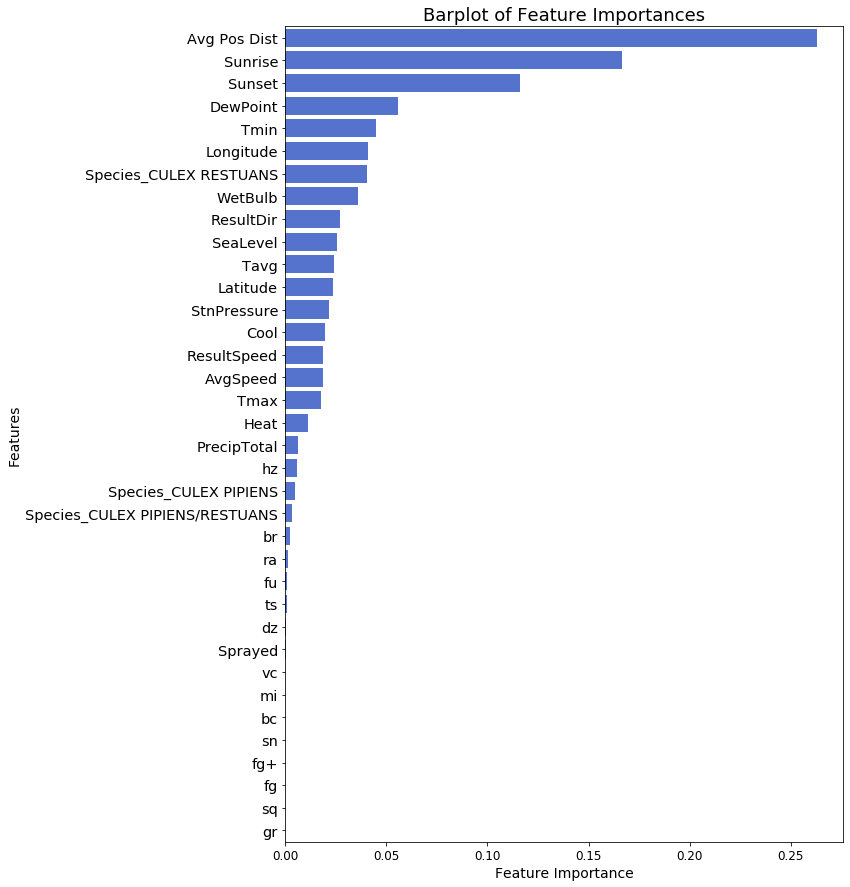

In [194]:
# Plotting barplot of features and the logreg coefs.

plt.figure(figsize=(10,15))

sns.barplot(orient='h', x=feature_imp_sorted, y=feature_names_sorted, color='royalblue')

# plt.tick_params(axis='x', labelrotation=25)

# Setting the size of axis ticks.
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=14.5)

plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)

plt.title("Barplot of Feature Importances", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplot_rfc_feature_importance.png', bbox_inches='tight');

The above barplot shows the importance of all the features in our *RandomForestClassifier* model. As mentioned in the EDA section, the **top four most important features are *Avg Pos Dist* (newly engineered feature), *Sunrise*, *Sunset* and *DewPoint***.

The engineered feature ***Avg Pos Dist* (the average distance of previously positively tested mosquito traps from each individual trap being tested) turned out to be the most important feature** in our model to predict the presence of WNV. This feature was engineered to take into account the spatial correlation between the mosquito traps around Chicago.

Shown in the table below are the evaluation scores for one of our preliminary *RandomForestClassifier* models with and without this engineered feature *Avg Pos Dist*. The scores clearly show that **introducing this feature into our model significantly increased the model's performance**.

In [195]:
comparison_df = pd.DataFrame(columns=['Classifier', 'Train Accuracy', 'Test Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC', 'Kaggle ROC-AUC'])
comparison_df.loc[1] = ["RFC without Avg. Pos. Dist.", 0.662, 0.658, 0.904, 0.643, 0.855, 0.710]
comparison_df.loc[2] = ["RFC with Avg. Pos. Dist.", 0.732, 0.722, 0.904, 0.712, 0.889, 0.722]
comparison_df

,Classifier,Train Accuracy,Test Accuracy,Sensitivity,Specificity,ROC-AUC,Kaggle ROC-AUC
1,RFC without Avg. Pos. Dist.,0.662,0.658,0.904,0.643,0.855,0.710
2,RFC with Avg. Pos. Dist.,0.732,0.722,0.904,0.712,0.889,0.722


One thing to note while reading the above barplot is that the feature importances shown here are the impurity-based feature importances. According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_), impurity-based feature importances can be misleading for high cardinality features (many unique values). In such cases, it may be better to calculate the feature importances using the *sklearn.inspection.permutation_importance* function.

### ROC Curve

In [196]:
# Creating a dataframe of actual values from y_test and of predicted probabilities of positive class from y_pred_proba.

pred_df = pd.DataFrame({'true_values' : y_test,
                        'pred_probs' : y_pred_proba7[:, 1]
                       })
pred_df.head(10)

,true_values,pred_probs
3391,0,0.027787
6660,0,0.063784
4820,0,0.070213
8132,0,0.656425
2155,0,0.602300
3220,0,0.041889
8271,0,0.289353
6686,0,0.014251
1715,0,0.719386
2259,0,0.170740


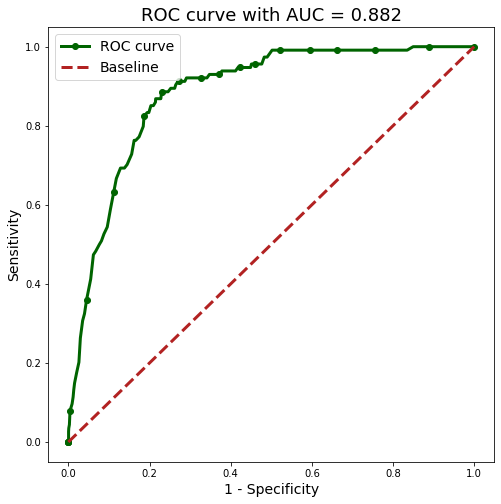

In [197]:
# Plotting the ROC curve to visualize the area under it (AUC).

plt.figure(figsize = (8,8))

# Creating threshold values (plotted as dashed line in plot below).
thresholds = np.linspace(0, 1, 200)

# Defining a function to calculate Sensitivity (True Positive Rate).
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Defining a function to calculate 1 - Specificity (1 - True Negative Rate).
def TNR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculating Sensitivity & 1 - Specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
tnr_values = [TNR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plotting the ROC curve.
plt.plot(tnr_values, tpr_values, label='ROC curve', linewidth=3, color='darkgreen', markevery=10, marker='o')

# Plotting the baseline, ie. perfect overlap between the two populations.
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='Baseline', linestyle='--', linewidth=3, color='firebrick')

plt.legend(fontsize=14);

plt.ylabel('Sensitivity', fontsize=14)
plt.xlabel('1 - Specificity', fontsize=14)

plt.title(f'ROC curve with AUC = {round(roc_auc7, 3)}', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/roc_auc_curve.png', bbox_inches='tight');

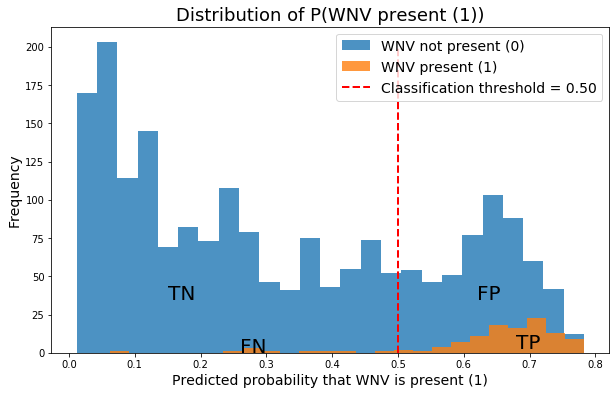

In [198]:
# Plotting the distribution of the two classes to visualize their separation.

plt.figure(figsize = (10,6))

# Creating two histograms of observations.
plt.hist(pred_df[pred_df['true_values']==0]['pred_probs'],
         bins = 25,
         alpha = 0.8,
         label = 'WNV not present (0)'
        )

plt.hist(pred_df[pred_df['true_values']==1]['pred_probs'],
         bins = 25,
         alpha = 0.8,
         label = 'WNV present (1)'
        )

# Adding a vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5, ymin = 0, ymax = 200, label = 'Classification threshold = 0.50', color='r', linestyle = '--', lw=2)

# Adding annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.15, 35), s = 'TN', size = 20)
plt.annotate(xy = (0.26, 0), s = 'FN', size = 20)
plt.annotate(xy = (0.68, 3), s = 'TP', size = 20)
plt.annotate(xy = (0.62, 35), s = 'FP', size = 20)

plt.title('Distribution of P(WNV present (1))', fontsize=18)

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Predicted probability that WNV is present (1)', fontsize=14)

# Create legend.
plt.legend(fontsize=14)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/outcome_class_separation.png', bbox_inches='tight');

In [199]:
conf_mat7

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,104 (True Pos),541 (False Pos)
Predicted WnvPresent=0,10 (False Neg),1421 (True Neg)


The above plot shows the *ROC* curve for our model with an *AUC* value of 0.882. The histogram plot shows the distribution of the sample populations from the two classes - positive class *(WnvPresent = 1)* & negative class *(WnvPresent = 0)* - and how well they are separated. As is evident from the plot, the two sample populations are not separated very obviously. So, we decided to keep the **classification threshold value at 0.50 for the predicted probabilities**. Increasing the threshold value would have resulted in more false negatives, while reducing the threshold value would have resulted in lesser false negatives, but a significantly more number of false positives.

### Visualizing the Predictions

In [200]:
# Creating a copy of test for plotting on an interactive map.
test_copy = test.copy()

# Merging the test_copy dataframe with the predictions dataframe from final chosen RandomForestClassifier model.
test_copy = pd.merge(left=test_copy, right=sub7, on='Id', how='left')

# Setting the date column as index.
test_copy.set_index('Date', inplace=True)

In [201]:
test_copy['Latitude'].min(), test_copy['Latitude'].max()

(41.644612, 42.01743)

In [202]:
test_copy['Longitude'].min(), test_copy['Longitude'].max()

(-87.930995, -87.531635)

In [203]:
# Setting the coordinates of lower left corner and upper right corner of the map image for plotting.

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

In [204]:
# Creating a list of unique years found in the train data.

test_years = list(test_copy.index.year.unique())
test_years

[2008, 2010, 2012, 2014]

In [205]:
# Creating a list of unique months found in the train data.

test_months = list(test_copy.index.month.unique())
test_months

[6, 7, 8, 9, 10]

In [206]:
# Defining a function to polt an interactive scatter plot with the mapdata as background.
# The function accepts the year and month values as input from the user interaction
# and plots the Latitude and Longitude coordinates, using WnvPresent (predicted probabilities of positive class) column for colour.

def test_lat_long_plotter(Year=test_years[0], Month=test_months[0]):
    
    plt.figure(figsize=(9,9))
    
    # Setting the mapdata image as the background of the map.
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
    
    # Converting the user input Year and Month values to type string for easier filtering of dataframe later.
    year = str(Year)
    month = 0
    if Month<10:
        month = "0"+str(Month)
    else:
        month = str(Month)
        
    date_str = year+"-"+month
    
    # Creating empty dataframes for WnvPresent=0 and WnvPresent=1 with only Latitude and Longitude columns.
    temp_df_0 = pd.DataFrame(columns=['Latitude', 'Longitude', 'WnvPresent'])
    temp_df_1 = pd.DataFrame(columns=['Latitude', 'Longitude', 'WnvPresent'])
    
    # Filtering the test_copy dataframe by WnvPresent <0.50 & >= 0.50 and by the date string defined above.
    # Taking only Latitude, Longitude and WnvPresent (predicted probabilities of positive class) columns and assigning them to empty dataframes created above.
    # We use try-except loops so as to suppress KeyErrors in case the filtered dataframes happen to be empty for the given date string.
    try:
        mask_0 = test_copy['WnvPresent']<0.5
        temp_df_0 = test_copy[mask_0][date_str].loc[:, ['Latitude', 'Longitude', 'WnvPresent']]
    except:
        pass
    
    try:
        mask_1 = test_copy['WnvPresent']>=0.5
        temp_df_1 = test_copy[mask_1][date_str].loc[:, ['Latitude', 'Longitude', 'WnvPresent']]
    except:
        pass
    
    plt.title("Map showing predictions about presence of WNV across Chicago", fontsize=18)
    
    plt.scatter(x=temp_df_0['Longitude'], y=temp_df_0['Latitude'], c='blue', marker='o', s=20)
    plt.scatter(x=temp_df_1['Longitude'], y=temp_df_1['Latitude'], c='red', marker='o', s=60)
    
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    
    plt.legend(fontsize=12, labels=['WNV not present (0)', 'WNV present (1)'])

In [207]:
interact(test_lat_long_plotter, Year=test_years, Month=test_months);

interactive(children=(Dropdown(description='Year', options=(2008, 2010, 2012, 2014), value=2008), Dropdown(des…

### Cost-Benefit Analysis

The insecticide that we recommend is Zenivex. It has proven to be effective in eliminating mosquitoes that carry West Nile Virus. It degrades rapidly and it is also harmless to humans and pets. Hence, it is an excellent choice for mosquitoes control (source: [CBS Chicago](https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/)).

The calculations below are based on a sample size of 2076 readings with our model built on 8304 readings.

Model Performance:  
**Accuracy: 73.4%**  
**Recall: 91.2%**  
**Specificity: 72.4%**

**Our model was optimised such that we have minimal *false negatives* (as shown by our *recall* score). Even though this resulted in more *false positives*, we find that it is a worthy tradeoff as the cost of spraying is much cheaper than the cost of medical expenses and productivity loss, as shown below.**

- Price/fluid-ounce is USD 22,948.75 / 35200 = USD 0.65

- 1.5 fluid cost/acre = USD 0.65 * 1.5 = USD 0.97/acre

- Spray location in sqm = 3.14 * (100m^2) = 31,400sqm
- 1 acre = 4046.86sqm so 1 spray location = USD 0.97 * (31400/4046.86) = **USD 7.52 (excl. overhead costs)**

**If even a single person contracted the virus in a given area, medical costs would vastly exceed the cost of spraying said location at USD 7.52.**

WNND: Mild Cases: USD 6,317 and Severe Cases: USD 33,143; Productivity Loss: USD 10,800

WNF: Medical Cost: USD 167 and Productivity Loss: USD 955
(source: [NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/))

### Deployment of Model

We have also deployed our model so that it can be used by the relevant departments such as the operations team to identify the locations that require spraying. This can also be used in other cities/states. The engine works such that anyone can upload a CSV file with the features that are needed for predictions and a table indicating the presence of West Nile Virus will be generated.

However, the main limitation is that the model was deployed on our local server using a *flask* application. We can look into improving it by deploying it to cloud. We can also improve the frontend interface so that it can provide more useful information and visualizations.

## Conclusions and Recommendations

We have selected the *RandomForestClassifier* with hyperparameter *class_weight='balanced_subsample'* as our model of choice, with what we deemed was the best balance between *accuracy* and *sensitivity* (due to the nature of our prediction being disease related and the minimisation of *false negatives* are imperative). *RandomForestClassifier* performed the best in these two metrics when compared to *LogisticRegression, GradientBoosting* and *SVC* models. *RandomForestClassifier* also performed relatively well with *SMOTE* as our balancing technique, however comparing the significant increase in *sensitivity*, we felt that a slight decrease in *accuracy* using *class_weight='balanced_subsample'* was justified. Other balancing techniques such as *ADASYN* and *ClusterCentroids* were considered as well. However, *ADASYN* was inferior to our selection and *ClusterCentroids* is an undersampling technique that brought the negative class down to a number that would be detrimental to the model performance.

The model was created based on the data of 8304 readings in Chicago between 2007 and 2013. The applicability of this model can be brought over and applied to other states across the United States as it generalizes quite well as was seen in our test sample.

There are a few limitations to our model and our data. Due to the imbalanced nature of our positive and negative classes, we have had to use balancing techniques which are weightage inflation and oversampling methods. Acquiring more data would be better in reducing this phenomena and aid in generating a more reliable model.

The hyperparameters involved in the instantiation of our model were based on a trial and error method in maximising both *accuracy* and *sensitivity*, as *GridSearchCV* prioritises a singular metric and not a balance of two. There may be a combination of hyperparameter settings that could have done better and could have been missed out during the trial and error phase, as there are too many variations of such combinations to have been covered.

The features involved that took the predominant influence on our models were *Average Positive Distance, Sunrise, Sunset* and *DewPoint*. *Average Positive Distance* was a newly engineered feature based on the average distance of previously positively tested mosquito traps from each individual trap being tested. These are factors to be looked into when considering the presence of West Nile Virus in a particular location. Due to the nature of our features being beyond what is humanly controllable, mitigation efforts can be only limited to methods such as spraying - which would be done in locations churned within our model based on the aforementioned features.

**Mitigation efforts to curb the spread of West Nile Virus should not be the responsibility of the state alone, especially when considering households and their individual influences on mosquito population.** The state could further educate the population through campaigns and programmes on measures and steps to take at home or within their communities. Integrated vector management programs should be carried out and the severity of the disease should be communicated to the public in a manner to illicit preventive action without reliance on statutory intervention.